# ETL
En esta notebook transformaremos nuestros archivos .csv, provistos por la iniciativa Open Data de la Ciudad de Buenos Aires. Los archivos están desordenados, en distintos formatos y separados por mes. Mediante una serie de transformaciones, convertiremos y uniremos todos estos datos en un dataset para cada estudio, según el objetivo y la información que se puede extraer.

## Setup de librerías
El siguiente bloque debe ejecutarse cada vez al inicio de una sesión de computación.

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from scipy.stats import norm
import os
import glob
import pandas as pd
import requests
from io import StringIO
from bs4 import BeautifulSoup
import warnings
from scipy import stats

## Obtención de archivos
Los archivos .csv están en: https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-de-peaje-ausa. Sin embargo, los hipervínculos provistos ofrecen archivos de formatos distintos para cada año, incluidos formatos .csv, .xlsx y .zip. Para normalizar estas diferencias, utilizaremos un servidor FTP propiedad del grupo.

In [2]:
# Headers necesarios para acceder a los archivos
headers = {'User-Agent': 'Mozilla/5.0'}
ftp = 'https://libryco.com/cdd/'

In [3]:
# Función para convertir en un dataframe el archivo de un año enviado por param
def get_dataframe(year):
  # Acceder al archivo ftp
  url = ftp + f"flujo-vehicular-{year}.csv"
  response = requests.get(url, headers=headers)

  # Chequear si la respuesta fue exitosa
  if response.status_code == 200:
      # Cargar csv y devolverlo
      data = pd.read_csv(StringIO(response.text), low_memory=False)
      print(f"Archivo del año {year} cargado exitosamente.")
      return data
  else:
      print(f"Error buscando archivo del año {year}): {response.status_code}")
      return None

# Definición de columnas

Para unificar los datasets, se analizan los distintos datasets de manera individual y se establecieron las siguientes columnas que se utilizarán en el dataset final:
1.   **ID Peaje (id_peaje):** Código identificador de la unidad de peaje. Tenemos un total de 12 peajes distintos, tipificados de la siguiente forma:

| id_peaje | descripcion_peaje    |
|----------|----------------------|
| AVE      | Avellaneda           |
| DEC      | Dellepiane centro |
| ALB      | Alberdi              |
| ILL      | Illia                |
| RET      | Retiro            |
| SAL      | Salguero             |
| SAR      | Sarmiento            |


2.   **Fecha** *(fecha):* Codificado como Año-Mes-Día.
3.   **Día de la semana** *(dia):* Decidimos añadir esta columna porque nos resulta relevante para la predicción de pasos.
4.   **Hora** *(hora):* Numérica, entera. Es la hora del día en la que empezaron a registrarse los pasos.
5.   **Tipo vehículo** *(tipo_vehiculo):* El tipo de vehículo del que se han registrado los pasos.
6.   **Tipo cobro** *(tipo_cobro):* El medio de pago utilizado. Está tipificado de esta manera:

| Columna            | Descripción                                             |
|--------------------|---------------------------------------------------------|
| Efectivo           | Pago realizado en efectivo                              |
| Exento             | Exento de pago, es decir, no se requiere realizar pago   |
| Monedero virtual       | Pago realizado a través de la plataforma Mercado Pago    |
| Rec.Deuda          | Reconocimiento de deuda, registro de una deuda           |
| Tarjeta Magnetica  | Pago realizado con una tarjeta magnética de discapacidad                 |
| Tag                | Pago mediante un dispositivo electrónico (peaje automático) |
| Infraccion          | Indica que no se realizó el pago         |
| Otro                | Se utilizó otro medio de pago


7.   **Pasos** *(pasos):* Cantidad de vehículos registrados.
8.   **Sentido** *(sentido):* Dirección en la que se registraron los pasos. "Centro" para el interior de CABA, "Provincia" para el interior.


# Unificación de datasets

## Preparación año 2016

### Análisis de columnas

Se recupera el archivo de datos del 2016 y se imprimen sus columnas junto con una muestra de valores para comenzar el análisis para la unificación.

In [4]:
data_2016 = get_dataframe(2016)
print("### INFO DEL DATASET 2016 ###")
print(data_2016.info())
print()
print("############")
print()
print("### VALORES EN LAS COLUMNAS ###")
for columna in data_2016:
  print(f"\nNombre: {columna}")
  valores_unicos = data_2016[columna].unique()
  if len(valores_unicos) < 300:
    print(f"Valores: {valores_unicos}")
  else:
    print(f"Valores: {valores_unicos[:20]}...")

Archivo del año 2016 cargado exitosamente.
### INFO DEL DATASET 2016 ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379443 entries, 0 to 1379442
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1379443 non-null  int64 
 1   fecha           1379443 non-null  object
 2   hora_inicio     1379443 non-null  int64 
 3   hora_fin        1379443 non-null  int64 
 4   dia             1379443 non-null  object
 5   estacion        1379443 non-null  object
 6   sentido         1379443 non-null  object
 7   tipo_vehiculo   1379443 non-null  object
 8   forma_pago      1379443 non-null  object
 9   cantidad_pasos  1379443 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.2+ MB
None

############

### VALORES EN LAS COLUMNAS ###

Nombre: periodo
Valores: [2016]

Nombre: fecha
Valores: ['2016-01-01' '2016-01-02' '2016-01-03' '2016-01-04' '2016-01-05'
 '2016-01-06' '2016-01-07' '2016-01

### Cambios que deben implementarse

1.   Solo trabajaremos con la hora de inicio, así que se eliminará la columna hora_fin. También se eliminará la columna periodo.
2.   Se deben cambiar los nombres de las columnas para que se ajusten a los definidos:

| Nombre original   | Nuevo nombre      |
|-------------------|-------------------|
| fecha             | fecha             |
| dia               | dia               |
| hora_inicio       | hora              |
| estacion          | id_peaje          |
| sentido           | sentido           |
| tipo_vehiculo     | tipo_vehiculo     |
| forma_pago        | tipo_cobro        |
| cantidad_pasos    | pasos             |

3.   Los días de la semana deben corregirse para que estén con la correcta codificación, es decir, que no salten problemas con los caracteres especiales. Para esto se eliminarán los tildes.
4.   La estación debe codificarse según la tabla de identificadores de peajes.
5.   La forma de pago debe codificarse según la tabla de medios de pago.





### Implementación de cambios

Comenzamos haciendo una copia del dataset para modificar y luego hacemos los cambios.

In [5]:
clean_data_2016 = data_2016.copy()

# Empezamos eliminando las columnas innecesarias
cols_to_remove = ['periodo', 'hora_fin']

# Eliminamos las columnas
clean_data_2016.drop(columns=cols_to_remove, inplace=True)
clean_data_2016.sample(5)

,fecha,hora_inicio,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
1208967,2016-11-16,19,MiÃ©rcoles,Illia,Provincia,Pesado,EFECTIVO,1
640177,2016-06-17,6,Viernes,Retiro,Provincia,Liviano,EXENTO,8
1074105,2016-10-12,11,MiÃ©rcoles,Dellepiane Centro,Centro,Liviano,INFRACCION,11
463822,2016-05-02,15,Lunes,Avellaneda,Provincia,Pesado,EFECTIVO,10
1240980,2016-11-25,17,Viernes,Alberdi,Centro,Pesado,AUPASS,8


In [6]:
# Renombramos las columnas para que tengan los nombres esperados
renamed_columns = {
    'hora_inicio': 'hora',
    'estacion': 'id_peaje',
    'tipo_vehiculo': 'tipo_vehiculo',
    'forma_pago': 'tipo_cobro',
    'cantidad_pasos': 'pasos'
}

# Renombrar las columnas
clean_data_2016.rename(columns=renamed_columns, inplace=True)
clean_data_2016.sample(5)

,fecha,hora,dia,id_peaje,sentido,tipo_vehiculo,tipo_cobro,pasos
948907,2016-09-09,20,Viernes,Alberdi,Provincia,Pesado,INFRACCION,1
133381,2016-02-05,17,Viernes,Dellepiane Centro,Centro,Pesado,EFECTIVO,2
1178516,2016-11-08,22,Martes,Retiro,Provincia,Pesado,EFECTIVO,41
703041,2016-07-05,16,Martes,Dellepiane Centro,Centro,Liviano,EFECTIVO,1356
707860,2016-07-06,13,MiÃ©rcoles,Illia,Centro,Pesado,EXENTO,16


In [7]:
# Continuamos con la limpieza de los días
day_codification = {
    'SÃ¡bado': 'Sabado',
    'MiÃ©rcoles': 'Miercoles'
}

# Reemplazamos los valores en la columna 'dia'
clean_data_2016['dia'] = clean_data_2016['dia'].replace(day_codification)
clean_data_2016['dia'].unique()

array(['Viernes', 'Sabado', 'Domingo', 'Lunes', 'Martes', 'Miercoles',
       'Jueves'], dtype=object)

Los id_peaje se ajustan según la tabla:

| id_peaje | descripcion_peaje    |
|----------|----------------------|
| AVE      | Avellaneda           |
| DEC      | Dellepiane centro |
| ALB      | Alberdi              |
| ILL      | Illia                |
| RET      | Retiro II            |
| SAL      | Salguero             |
| SAR      | Sarmiento            |

El peaje que no se contempla en esta tabla (Dellepiane Liniers) se eliminará.

In [8]:
# Ajustamos los id_peaje
toll_codification = {
    'Alberdi': 'ALB',
    'Avellaneda': 'AVE',
    'Dellepiane Centro': 'DEC',
    'Illia': 'ILL',
    'Retiro': 'RET',
    'Salguero': 'SAL',
    'Sarmiento': 'SAR'}

clean_data_2016['id_peaje'] = clean_data_2016['id_peaje'].replace(toll_codification)
clean_data_2016.drop(clean_data_2016[~clean_data_2016['id_peaje'].isin(toll_codification.values())].index, inplace=True)
clean_data_2016['id_peaje'].unique()

array(['ALB', 'AVE', 'DEC', 'ILL', 'RET', 'SAL', 'SAR'], dtype=object)

Las formas de pago se ajustan según la tabla:

| Columna            | Descripción                                             |
|--------------------|---------------------------------------------------------|
| Efectivo           | Pago realizado en efectivo                              |
| Exento             | Exento de pago, es decir, no se requiere realizar pago   |
| Monedero virtual       | Pago realizado a través de la plataforma Mercado Pago    |
| Rec.Deuda          | Reconocimiento de deuda, registro de una deuda           |
| Tarjeta Magnetica  | Pago realizado con una tarjeta magnética                 |
| Tag                | Pago mediante un dispositivo electrónico (peaje automático) |
| Infraccion          | Indica que no se realizó el pago         |
| Otro                | Se utilizó otro medio de pago



In [9]:
# Por último, ajustamos los medios de pago
payment_codification = {
    'NO COBRADO': 'Rec.Deuda',
    'AUPASS': 'Tag',
    'EFECTIVO': 'Efectivo',
    'EXENTO': 'Exento',
    'TARJETA DISCAPACIDAD': 'Tarjeta Magnetica',
    'INFRACCION': 'Infraccion',
    'MONEDERO': 'Monedero virtual'
}

clean_data_2016['tipo_cobro'] = clean_data_2016['tipo_cobro'].replace(payment_codification)
clean_data_2016['tipo_cobro'].unique()

array(['Rec.Deuda', 'Tag', 'Efectivo', 'Exento', 'Tarjeta Magnetica',
       'Infraccion', 'Monedero virtual'], dtype=object)

In [10]:
# Observamos que el dataset quede construido correctamente
clean_data_2016.sample(10)

,fecha,hora,dia,id_peaje,sentido,tipo_vehiculo,tipo_cobro,pasos
1074173,2016-10-12,14,Miercoles,DEC,Centro,Liviano,Efectivo,91
1180511,2016-11-09,13,Miercoles,DEC,Centro,Liviano,Efectivo,119
878109,2016-08-21,6,Domingo,AVE,Provincia,Pesado,Tag,3
258799,2016-03-09,8,Miercoles,AVE,Centro,Liviano,Efectivo,85
190703,2016-02-20,20,Sabado,ILL,Centro,Pesado,Tag,2
937264,2016-09-06,17,Martes,ALB,Provincia,Pesado,Efectivo,2
292247,2016-03-17,6,Jueves,ILL,Centro,Pesado,Tag,5
346397,2016-04-01,9,Viernes,AVE,Centro,Pesado,Efectivo,24
1212418,2016-11-17,15,Jueves,ILL,Centro,Liviano,Tag,1
1196586,2016-11-13,9,Domingo,ILL,Centro,Liviano,Tag,225


## Preparación año 2017


### Análisis de columnas

Se analizan las columnas del dataset para identificar los cambios que deben hacerse para la unificación.

In [11]:
data_2017 = get_dataframe(2017)
print("### INFO DEL DATASET 2017 ###")
print(data_2017.info())
print()
print("############")
print()
print("### VALORES EN LAS COLUMNAS ###")
for columna in data_2017:
  print(f"\nNombre: {columna}")
  valores_unicos = data_2017[columna].unique()
  if len(valores_unicos) < 300:
    print(f"Valores: {valores_unicos}")
  else:
    print(f"Valores: {valores_unicos[:20]}...")

Archivo del año 2017 cargado exitosamente.
### INFO DEL DATASET 2017 ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB
None

############

### VALORES EN LAS COLUMNAS ###

Nombre: periodo
Valores: [2017]

Nombre: fecha
Valores: ['2017-01-01' '2017-01-02' '2017-01-03' '2017-01-04' '2017-01-05'
 '2017-01-06' '2017-01-07' '2017-01

### Cambios que deben implementarse

Se puede ver que el dataset es muy parecido al del año 2016, así que se aplicará el mismo procesamiento. La diferencia aparece en la forma de pago, en donde el "Telepase" contará como Tag y "Otros" tendrá su propia categoría.

### Implementación de cambios

In [12]:
clean_data_2017 = data_2017.copy()

# Empezamos eliminando las columnas innecesarias
cols_to_remove = ['periodo', 'hora_fin']

# Eliminamos las columnas
clean_data_2017.drop(columns=cols_to_remove, inplace=True)

# Renombramos las columnas para que tengan los nombres esperados
renamed_columns = {
    'hora_inicio': 'hora',
    'estacion': 'id_peaje',
    'tipo_vehiculo': 'tipo_vehiculo',
    'forma_pago': 'tipo_cobro',
    'cantidad_pasos': 'pasos'
}

# Renombrar las columnas
clean_data_2017.rename(columns=renamed_columns, inplace=True)

# Continuamos con la limpieza de los días
day_codification = {
    'SÃ¡bado': 'Sabado',
    'MiÃ©rcoles': 'Miercoles'
}

# Reemplazamos los valores en la columna 'dia'
clean_data_2017['dia'] = clean_data_2017['dia'].replace(day_codification)

# Ajustamos los id_peaje
toll_codification = {
    'Alberdi': 'ALB',
    'Avellaneda': 'AVE',
    'Dellepiane Centro': 'DEC',
    'Illia': 'ILL',
    'Retiro': 'RET',
    'Salguero': 'SAL',
    'Sarmiento': 'SAR'}

clean_data_2017['id_peaje'] = clean_data_2017['id_peaje'].replace(toll_codification)
clean_data_2017.drop(clean_data_2017[~clean_data_2017['id_peaje'].isin(toll_codification.values())].index, inplace=True)

# Por último, ajustamos los medios de pago, este es el único código que varía con respecto al 2016
payment_codification = {
    'NO COBRADO': 'Rec.Deuda',
    'TELEPASE': 'Tag',
    'EFECTIVO': 'Efectivo',
    'EXENTO': 'Exento',
    'TARJETA DISCAPACIDAD': 'Tarjeta Magnetica',
    'INFRACCION': 'Infraccion',
    'MONEDERO': 'Monedero virtual',
    'Otros': 'Otro'
}

clean_data_2017['tipo_cobro'] = clean_data_2017['tipo_cobro'].replace(payment_codification)

# Imprimimos algunas filas de la tabla para ver el cambio
clean_data_2017.sample(10)

,fecha,hora,dia,id_peaje,sentido,tipo_vehiculo,tipo_cobro,pasos
367777,2017-04-08,19,Sabado,SAR,Provincia,Liviano,Tag,189
557369,2017-05-29,12,Lunes,ILL,Centro,Pesado,Tag,40
71295,2017-01-20,18,Viernes,ALB,Centro,Liviano,Exento,7
1018556,2017-09-29,19,Viernes,AVE,Centro,Pesado,Tarjeta Magnetica,1
1265022,2017-12-02,21,Sabado,ILL,Provincia,Liviano,Infraccion,1
915855,2017-09-01,19,Viernes,SAR,Provincia,Liviano,Rec.Deuda,27
1214703,2017-11-19,7,Domingo,ILL,Provincia,Liviano,Efectivo,36
1250909,2017-11-29,8,Miercoles,AVE,Provincia,Pesado,Efectivo,158
885206,2017-08-24,9,Jueves,ILL,Provincia,Pesado,Infraccion,1
846684,2017-08-14,23,Lunes,DEC,Centro,Pesado,Efectivo,10


## Preparación año 2018

### Análisis de columnas

Se analizan las columnas del dataset para identificar los cambios que deben hacerse para la unificación.

In [13]:
data_2018 = get_dataframe(2018)
print("### INFO DEL DATASET 2018 ###")
print(data_2018.info())
print()
print("############")
print()
print("### VALORES EN LAS COLUMNAS ###")
for columna in data_2018:
  print(f"\nNombre: {columna}")
  valores_unicos = data_2018[columna].unique()
  if len(valores_unicos) < 300:
    print(f"Valores: {valores_unicos}")
  else:
    print(f"Valores: {valores_unicos[:20]}...")

Archivo del año 2018 cargado exitosamente.
### INFO DEL DATASET 2018 ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB
None

############

### VALORES EN LAS COLUMNAS ###

Nombre: periodo
Valores: [2018]

Nombre: fecha
Valores: ['2018-01-01' '2018-01-02' '2018-01-03' '2018-01-04' '2018-01-05'
 '2018-01-06' '2018-01-07' '2018-01

### Cambios que deben implementarse

Se puede ver que el dataset es muy parecido al de los años anteriores, así que se aplicará el mismo procesamiento.

### Implementación de cambios

In [14]:
clean_data_2018 = data_2018.copy()

# Empezamos eliminando las columnas innecesarias
cols_to_remove = ['periodo', 'hora_fin']

# Eliminamos las columnas
clean_data_2018.drop(columns=cols_to_remove, inplace=True)

# Renombramos las columnas para que tengan los nombres esperados
renamed_columns = {
    'hora_inicio': 'hora',
    'estacion': 'id_peaje',
    'tipo_vehiculo': 'tipo_vehiculo',
    'forma_pago': 'tipo_cobro',
    'cantidad_pasos': 'pasos'
}

# Renombrar las columnas
clean_data_2018.rename(columns=renamed_columns, inplace=True)

# Continuamos con la limpieza de los días
day_codification = {
    'SÃ¡bado': 'Sabado',
    'MiÃ©rcoles': 'Miercoles'
}

# Reemplazamos los valores en la columna 'dia'
clean_data_2018['dia'] = clean_data_2018['dia'].replace(day_codification)

# Ajustamos los id_peaje
toll_codification = {
    'Alberdi': 'ALB',
    'Avellaneda': 'AVE',
    'Dellepiane Centro': 'DEC',
    'Illia': 'ILL',
    'Retiro': 'RET',
    'Salguero': 'SAL',
    'Sarmiento': 'SAR'}

clean_data_2018['id_peaje'] = clean_data_2018['id_peaje'].replace(toll_codification)
clean_data_2018.drop(clean_data_2018[~clean_data_2018['id_peaje'].isin(toll_codification.values())].index, inplace=True)

# Por último, ajustamos los medios de pago
payment_codification = {
    'NO COBRADO': 'Rec.Deuda',
    'TELEPASE': 'Tag',
    'EFECTIVO': 'Efectivo',
    'EXENTO': 'Exento',
    'TARJETA DISCAPACIDAD': 'Tarjeta Magnetica',
    # se considera a la tarjeta de discapacidad como un tipo exento de pago
    'INFRACCION': 'Infraccion'
}

clean_data_2018['tipo_cobro'] = clean_data_2018['tipo_cobro'].replace(payment_codification)

# Imprimimos algunas filas de la tabla para ver el cambio
clean_data_2018.sample(10)

,fecha,hora,dia,id_peaje,sentido,tipo_vehiculo,tipo_cobro,pasos
660646,2018-06-26,17,Martes,DEC,Centro,Liviano,Efectivo,1021
1010856,2018-09-27,1,Jueves,DEC,Centro,Pesado,Efectivo,5
620824,2018-06-14,8,Jueves,ILL,Centro,Pesado,Efectivo,9
356127,2018-04-05,7,Jueves,AVE,Centro,Liviano,Tag,2615
439801,2018-04-27,2,Viernes,AVE,Centro,Pesado,Tag,10
838875,2018-08-12,15,Domingo,ILL,Provincia,Pesado,Tag,22
173164,2018-02-16,19,Viernes,ALB,Provincia,Pesado,Tag,3
1053773,2018-10-08,17,Lunes,DEC,Centro,Pesado,Efectivo,1
66735,2018-01-18,11,Jueves,ILL,Provincia,Pesado,Exento,5
293358,2018-03-19,14,Lunes,DEC,Centro,Liviano,Tag,1


## Preparación año 2019

### Análisis de columnas

Se analizan las columnas del dataset para identificar los cambios que deben hacerse para la unificación.

In [15]:
data_2019 = get_dataframe(2019)
print("### INFO DEL DATASET 2019 ###")
print(data_2019.info())
print()
print("############")
print()
print("### VALORES EN LAS COLUMNAS ###")
for columna in data_2019:
  print(f"\nNombre: {columna}")
  valores_unicos = data_2019[columna].unique()
  if len(valores_unicos) < 300:
    print(f"Valores: {valores_unicos}")
  else:
    print(f"Valores: {valores_unicos[:20]}...")

Archivo del año 2019 cargado exitosamente.
### INFO DEL DATASET 2019 ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB
None

############

### VALORES EN LAS COLUMNAS ###

Nombre: periodo
Valores: [2019]

Nombre: fecha
Valores: ['2019-01-01' '2019-02-01' '2019-03-01' '2019-04-01' '2019-05-01'
 '2019-06-01' '2019-07-01' '2019-08-01' '2019-09-0

### Cambios que deben implementarse

Se puede ver que el dataset es muy parecido al de los años anteriores, así que se aplicará el mismo procesamiento.

La diferencia aparece en la columna de los peajes, donde hay un peaje nuevo ("PDB"), que no está entre el listado de peajes que queremos considerar. Se eliminarán las filas que contengan este peaje.

### Implementación de cambios

In [16]:
clean_data_2019 = data_2019.copy()

# Empezamos eliminando las columnas innecesarias
cols_to_remove = ['periodo', 'hora_fin']

# Eliminamos las columnas
clean_data_2019.drop(columns=cols_to_remove, inplace=True)

# Renombramos las columnas para que tengan los nombres esperados
renamed_columns = {
    'hora_inicio': 'hora',
    'estacion': 'id_peaje',
    'forma_pago': 'tipo_cobro',
    'cantidad_pasos': 'pasos'
}

# Renombrar las columnas
clean_data_2019.rename(columns=renamed_columns, inplace=True)

# Continuamos con la limpieza de los días
day_codification = {
    'SÃ¡bado': 'Sabado',
    'MiÃ©rcoles': 'Miercoles'
}

# Reemplazamos los valores en la columna 'dia'
clean_data_2019['dia'] = clean_data_2019['dia'].replace(day_codification)

# Ajustamos los id_peaje
toll_codification = {
    'Alberti': 'ALB',
    'Avellaneda': 'AVE',
    'Dellepiane': 'DEC',
    'Illia': 'ILL',
    'Retiro': 'RET',
    'Salguero': 'SAL',
    'Sarmiento': 'SAR'}

clean_data_2019['id_peaje'] = clean_data_2019['id_peaje'].replace(toll_codification)
clean_data_2019.drop(clean_data_2019[~clean_data_2019['id_peaje'].isin(toll_codification.values())].index, inplace=True)

# Por último, ajustamos los medios de pago
payment_codification = {
    'NO COBRADO': 'Rec.Deuda',
    'TELEPASE': 'Tag',
    'EFECTIVO': 'Efectivo',
    'EXENTO': 'Exento',
    'T. DISCAPACIDAD': 'Tarjeta Magnetica',
    'INFRACCION': 'Infraccion'
}

clean_data_2019['tipo_cobro'] = clean_data_2019['tipo_cobro'].replace(payment_codification)

# Imprimimos algunas filas de la tabla para ver el cambio
clean_data_2019.sample(10)

,fecha,hora,dia,id_peaje,sentido,tipo_vehiculo,tipo_cobro,pasos
737814,2019-11-29,23,Viernes,ILL,Provincia,Pesado,Exento,1
78868,2019-07-02,16,Martes,ILL,Centro,Liviano,Tag,1120
453920,2019-07-31,2,Miercoles,AVE,Centro,Pesado,Rec.Deuda,1
800680,2019-12-26,21,Jueves,AVE,Centro,Liviano,Tag,798
565100,2019-09-17,6,Martes,AVE,Provincia,Pesado,Tag,263
348150,2019-06-14,17,Viernes,ALB,Provincia,Liviano,Exento,5
174774,2019-03-25,8,Lunes,AVE,Provincia,Liviano,Exento,46
222897,2019-04-16,22,Martes,SAR,Provincia,Liviano,Tag,122
347566,2019-06-14,11,Viernes,DEC,Provincia,Pesado,Tarjeta Magnetica,1
708265,2019-11-17,11,Domingo,SAR,Provincia,Liviano,Tag,354


## Preparación año 2020

### Análisis de columnas

Se analizan las columnas del dataset para identificar los cambios que deben hacerse para la unificación.

In [17]:
data_2020 = get_dataframe(2020)
print("### INFO DEL DATASET 2020 ###")
print(data_2020.info())
print()
print("############")
print()
print("### VALORES EN LAS COLUMNAS ###")
for columna in data_2020:
  print(f"\nNombre: {columna}")
  valores_unicos = data_2020[columna].unique()
  if len(valores_unicos) < 300:
    print(f"Valores: {valores_unicos}")
  else:
    print(f"Valores: {valores_unicos[:20]}...")

Archivo del año 2020 cargado exitosamente.
### INFO DEL DATASET 2020 ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2533743 entries, 0 to 2533742
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   periodo         float64
 1   fecha           object 
 2   mes             object 
 3   dia             object 
 4   dia_fecha       float64
 5   hora_inicio     float64
 6   hora_fin        float64
 7   estacion        object 
 8   tipo_vehiculo   object 
 9   forma_pago      object 
 10  observacion     object 
 11  sentido         object 
 12  cantidad_pasos  float64
dtypes: float64(5), object(8)
memory usage: 251.3+ MB
None

############

### VALORES EN LAS COLUMNAS ###

Nombre: periodo
Valores: [2020.]

Nombre: fecha
Valores: ['2020-01-01 00:00:00' '2020-01-02 00:00:00' '2020-01-03 00:00:00'
 '2020-01-04 00:00:00' '2020-01-05 00:00:00' '2020-01-06 00:00:00'
 '2020-01-07 00:00:00' '2020-01-08 00:00:00' '2020-01-09 00:00:00'
 '2020-01-10 0

### Cambios que deben implementarse
A primera vista vemos que hay columnas de más, con información que si bien es útil podemos extraerla del resto de las columnas. Vamos a eliminarlas para asegurar consistencia con los otros años.

In [18]:
clean_data_2020 = data_2020.copy()

# Empezamos eliminando las columnas innecesarias
cols_to_remove = ['periodo', 'hora_fin', 'observacion', 'mes', 'dia_fecha']

# Eliminamos las columnas
clean_data_2020.drop(columns=cols_to_remove, inplace=True)

# Renombramos las columnas para que tengan los nombres esperados
renamed_columns = {
    'hora_inicio': 'hora',
    'estacion': 'id_peaje',
    'tipo_vehiculo': 'tipo_vehiculo',
    'forma_pago': 'tipo_cobro',
    'cantidad_pasos': 'pasos'
}

# Renombrar las columnas
clean_data_2020.rename(columns=renamed_columns, inplace=True)

# Continuamos con la limpieza de los días
day_codification = {
    'SÃ¡bado': 'Sabado',
    'MiÃ©rcoles': 'Miercoles'
}

# Reemplazamos los valores en la columna 'dia'
clean_data_2020['dia'] = clean_data_2020['dia'].replace(day_codification)

# Ajustamos los id_peaje
toll_codification = {
    'ALBERDI': 'ALB',
    'AVELLANEDA': 'AVE',
    'DELLEPIANE LINIERSLEPIANE CENTRO': 'DEC',
    'ILLIA': 'ILL',
    'RETIRO': 'RET',
    'SALGUERO': 'SAL',
    'SARMIENTO': 'SAR'}

clean_data_2020['id_peaje'] = clean_data_2020['id_peaje'].replace(toll_codification)
clean_data_2020.drop(clean_data_2020[~clean_data_2020['id_peaje'].isin(toll_codification.values())].index, inplace=True)

# Ajustamos los tipos de vehículo
type_codification = {
    'Auto': 'Liviano',
    'Auto con trailer': 'Liviano',
    'Moto': 'Liviano',
    'Pago doble Moto': 'Liviano',
    'Pago Doble Auto': 'Liviano',
    'Pago Doble Auto con trailer / Pesado 2 Ejes': 'Liviano',
    'Pesados 2 Ejes': 'Pesado',
    'Pesados 3 Ejes': 'Pesado',
    'Pesados 4 Ejes': 'Pesado',
    'Pesados 5 Ejes': 'Pesado',
    'Pesados 6 Ejes': 'Pesado',
    'N/D': None,
}

clean_data_2020['tipo_vehiculo'] = clean_data_2020['tipo_vehiculo'].replace(type_codification)

# Ajustamos los strings que deberían ser enteros
clean_data_2020['hora'] = clean_data_2020['hora'].astype(int)
clean_data_2020['pasos'] = clean_data_2020['pasos'].astype(int)

# Por último, ajustamos los medios de pago
payment_codification = {
    'Tarjeta MagnÃ©tica': 'Tarjeta Magnetica',
    'ViolaciÃ³n': 'Infraccion'
}
clean_data_2020['tipo_cobro'] = clean_data_2020['tipo_cobro'].replace(payment_codification)

# Imprimimos algunas filas de la tabla para ver el cambio
clean_data_2020.sample(10)

,fecha,dia,hora,id_peaje,tipo_vehiculo,tipo_cobro,sentido,pasos
1698494,2020-09-01,Martes,14,ILL,Liviano,Tag,Centro,11
868910,2020-05-30,Sabado,1,ILL,Liviano,Tag,Provincia,6
1683160,2020-09-25,Viernes,16,ILL,Liviano,Rec.Deuda,Centro,2
1380243,2020-07-08,Miercoles,21,AVE,Pesado,Efectivo,Centro,4
632226,2020-03-19 00:00:00,Jueves,18,AVE,Pesado,Efectivo,Centro,2
1246803,2020-07-21,Martes,20,AVE,Liviano,Efectivo,Provincia,382
1265115,2020-07-30,Jueves,0,RET,Liviano,Tag,Provincia,1
808723,2020-04-28,Martes,16,AVE,Pesado,Tag,Provincia,3
760580,2020-04-19,Domingo,12,SAL,Liviano,Tag,Provincia,1
1263815,2020-07-29,Miercoles,12,AVE,Liviano,Tag,Provincia,18


## Preparación año 2021

### Análisis de columnas

Se analizan las columnas del dataset para identificar los cambios que deben hacerse para la unificación.

In [19]:
data_2021 = get_dataframe(2021)
print("### INFO DEL DATASET 2021 ###")
print(data_2021.info())
print()
print("############")
print()
print("### VALORES EN LAS COLUMNAS ###")
for columna in data_2021:
  print(f"\nNombre: {columna}")
  valores_unicos = data_2021[columna].unique()
  if len(valores_unicos) < 300:
    print(f"Valores: {valores_unicos}")
  else:
    print(f"Valores: {valores_unicos[:20]}...")

Archivo del año 2021 cargado exitosamente.
### INFO DEL DATASET 2021 ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029367 entries, 0 to 3029366
Data columns (total 10 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   AÃ±o de Fecha Operativa  object
 1   Cat Cobrada              object
 2   DÃ­a de Fecha Operativa  object
 3   Hora HH                  object
 4   ID Peaje                 object
 5   Mes de Fecha Operativa   object
 6   Observacion              object
 7   Sentido                  object
 8   Tipo Cobro               object
 9   Pasos                    object
dtypes: object(10)
memory usage: 231.1+ MB
None

############

### VALORES EN LAS COLUMNAS ###

Nombre: AÃ±o de Fecha Operativa
Valores: ['2021' 'Total general']

Nombre: Cat Cobrada
Valores: ['Auto' 'Auto con trailer' 'Moto' 'N/D' 'Pago doble Moto' 'Pesados 2 Ejes'
 'Pesados 3 Ejes' 'Pesados 4 Ejes' 'Pesados 5 Ejes' 'Pesados 6 Ejes'
 'Total' 'Pago Doble Auto con trai

### Cambios necesarios



*   Hay que renombrar las columnas
*   Hay que eliminar las columnas con las que no vamos a trabajar
*   Hay que eliminar la fila con el valor "total" en todas las casillas
*   Hay que convertir en entero las columnas de la hora y de los pasos
*   Hay que unificar las fechas y agregar la columna "día de la semana"
*   Hay que asegurarse de que todos los valores categóricos estén dentro de las categorías que trabajamos



### Implementación de cambios


In [20]:
clean_data_2021 = data_2021.copy()

# Empezamos eliminando las columnas innecesarias
cols_to_remove = ['AÃ±o de Fecha Operativa', 'Observacion']

# Eliminamos las columnas
clean_data_2021.drop(columns=cols_to_remove, inplace=True)

# Renombramos las columnas para que tengan los nombres esperados
renamed_columns = {
    'Hora HH': 'hora',
    'ID Peaje': 'id_peaje',
    'Cat Cobrada': 'tipo_vehiculo',
    'Tipo Cobro': 'tipo_cobro',
    'Pasos': 'pasos',
    'Sentido': 'sentido'
}

# Renombrar las columnas
clean_data_2021.rename(columns=renamed_columns, inplace=True)

# Ajustamos los medios de pago
payment_codification = {
    'Tarjeta MagnÃ©tica': 'Tarjeta Magnetica',
    'ViolaciÃ³n': 'Infraccion',
    'CPP': 'Otro'
}

clean_data_2021['tipo_cobro'] = clean_data_2021['tipo_cobro'].replace(payment_codification)

# Ajustamos los tipos de vehículo
type_codification = {
    'Auto': 'Liviano',
    'Auto con trailer': 'Liviano',
    'Moto': 'Liviano',
    'Pago doble Moto': 'Liviano',
    'Pago Doble Auto': 'Liviano',
    'Pago Doble Auto con trailer / Pesado 2 Ejes': 'Liviano',
    'Pesados 2 Ejes': 'Pesado',
    'Pesados 3 Ejes': 'Pesado',
    'Pesados 4 Ejes': 'Pesado',
    'Pesados 5 Ejes': 'Pesado',
    'Pesados 6 Ejes': 'Pesado',
    'N/D': None,
    'nan': None
}

clean_data_2021['tipo_vehiculo'] = clean_data_2021['tipo_vehiculo'].replace(type_codification)

# Eliminar filas con valores nulos si es necesario
# clean_data_2021.dropna(subset=['tipo_vehiculo'], inplace=True)

# Eliminamos las filas con los id_peajes que no seleccionamos
tolls = ['ALB', 'AVE', 'DEC', 'ILL', 'RET', 'SAL', 'SAR']
clean_data_2021.drop(clean_data_2021[~clean_data_2021['id_peaje'].isin(tolls)].index, inplace=True)

# Eliminamos la última fila, que contiene la palabra "total" en las celdas
# y ajustamos los strings que deberían ser enteros
clean_data_2021.drop(clean_data_2021.index[-1], inplace=True)

clean_data_2021['hora'] = clean_data_2021['hora'].astype(int)
clean_data_2021['pasos'] = clean_data_2021['pasos'].astype(int)

# Imprimimos algunas filas de la tabla para ver el cambio
clean_data_2021.sample(10)

,tipo_vehiculo,DÃ­a de Fecha Operativa,hora,id_peaje,Mes de Fecha Operativa,sentido,tipo_cobro,pasos
127387,Pesado,16,4,ILL,abril,Centro,Tag,2
607098,Pesado,8,13,AVE,mayo,Centro,Tag,13
1875395,Liviano,29,14,AVE,septiembre,Centro,Exento,9
2524452,Liviano,1,7,ALB,noviembre,Provincia,Efectivo,92
879380,Pesado,22,8,DEC,febrero,Centro,Tag,13
1249185,Pesado,19,14,AVE,junio,Provincia,Exento,8
295039,Liviano,18,11,AVE,marzo,Provincia,Tag,2
1130512,Liviano,6,14,AVE,junio,Centro,Tag,92
2341195,Liviano,27,22,ILL,octubre,Provincia,Exento,3
2796009,Liviano,10,0,ALB,diciembre,Provincia,Mercado Pago,2


In [21]:
# Unificamos las fechas en una sola columna
month = {
    'enero': '01',
    'febrero': '02',
    'marzo': '03',
    'abril': '04',
    'mayo': '05',
    'junio': '06',
    'julio': '07',
    'agosto': '08',
    'septiembre': '09',
    'octubre': '10',
    'noviembre': '11',
    'diciembre': '12'
}

clean_data_2021['Mes de Fecha Operativa'] = clean_data_2021['Mes de Fecha Operativa'].replace(month)

# Creamos la nueva columna 'fecha' en el formato YYYY-MM-DD
clean_data_2021['fecha'] = '2021-' + clean_data_2021['Mes de Fecha Operativa'] + '-' + clean_data_2021['DÃ­a de Fecha Operativa'].str.zfill(2)

# Eliminamos las columnas que ya no necesitamos
clean_data_2021.drop(columns=['DÃ­a de Fecha Operativa', 'Mes de Fecha Operativa'], inplace=True)

# Construimos la columna día a partir de la fecha
date = pd.to_datetime(clean_data_2021['fecha'], format='%Y-%m-%d')
clean_data_2021['dia'] = date.dt.day_name()

days_conversor = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miercoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sabado',
    'Sunday': 'Domingo'
}

# Reemplazar los nombres en inglés por español
clean_data_2021['dia'] = clean_data_2021['dia'].replace(days_conversor)

clean_data_2021.sample(10)

,tipo_vehiculo,hora,id_peaje,sentido,tipo_cobro,pasos,fecha,dia
602229,Pesado,17,DEC,Centro,Efectivo,8,2021-05-31,Lunes
1294507,Pesado,1,AVE,Centro,Tag,1,2021-06-26,Sabado
2216235,Pesado,15,DEC,Centro,Rec.Deuda,1,2021-09-21,Martes
3027317,Pesado,11,AVE,Provincia,Tag,5,2021-12-28,Martes
1482047,Pesado,8,ILL,Centro,Rec.Deuda,1,2021-07-23,Viernes
2840358,Liviano,8,ILL,Provincia,Mercado Pago,11,2021-12-28,Martes
169739,Pesado,1,AVE,Centro,Efectivo,1,2021-04-06,Martes
1177369,Liviano,21,ILL,Centro,Rec.Deuda,2,2021-06-28,Lunes
1103871,Pesado,19,AVE,Provincia,Tag,1,2021-01-01,Viernes
1428580,Liviano,13,AVE,Provincia,Rec.Deuda,3,2021-07-29,Jueves


## Preparación año 2022

### Unificación de archivos mensuales
Este año y los que le siguen tienen la particularidad de tener separados por mes los archivos .csv, de manera que hay que unificarlos primero para tener consistencia con el resto de los años.

#### Obtención de archivos
Se recupera el archivo de datos de cada mes y se guarda en un arreglo.

In [22]:
# Ya no podemos usar la función get_dataframe() porque no disponemos de un .csv singular para todo el 2022, por lo que vamos a
# diseñar un código específico para la estructura de archivos de este año.
data_2022_split = []

# Lista con nombres de archivos
file_list = []
for i in range(1, 13):
  if i < 10:
    file_list.append(f"0{i}_2022.csv")
  else:
    file_list.append(f"{i}_2022.csv")

for file in file_list:
    url = ftp + "flujo-vehicular-2022/" + file

    # Acceder al archivo ftp
    response = requests.get(url, headers=headers)

    # Chequear si la respuesta fue exitosa
    if response.status_code == 200:
        # Cargar csv y agregarlo a la lista
        data = pd.read_csv(StringIO(response.text), low_memory=False, sep=';')
        data_2022_split.append(data)
        print(f"Archivo {url} cargado")
    else:
        print(f"Error buscando archivo {url}: {response.status_code}")

  #  TODO: ver de reordenar las columnas para que queden todas en la misma, por ej la de enero, febrero, marzo hay col en distinto orden

Archivo https://libryco.com/cdd/flujo-vehicular-2022/01_2022.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2022/02_2022.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2022/03_2022.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2022/04_2022.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2022/05_2022.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2022/06_2022.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2022/07_2022.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2022/08_2022.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2022/09_2022.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2022/10_2022.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2022/11_2022.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2022/12_2022.csv cargado


#### Proceso de unificación
Una vez concatenados los archivos mensuales, se crea el nuevo archivo para su posterior transformación y unificación con el resto.

In [23]:
# Unificación de archivos del anio 2022

# Concatenación
data_2022 = pd.concat(data_2022_split, ignore_index=True)

print("### INFO DEL DATASET 2022 ###")
print(data_2022.info())
print()
print("############")
print()
print("### VALORES EN LAS COLUMNAS ###")
for columna in data_2022:
  print(f"\nNombre: {columna}")
  valores_unicos = data_2022[columna].unique()
  if len(valores_unicos) < 300:
    print(f"Valores: {valores_unicos}")
  else:
    print(f"Valores: {valores_unicos[:20]}...")

### INFO DEL DATASET 2022 ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3124739 entries, 0 to 3124738
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   AÃ±o de Fecha Operativ  object 
 1   Hora HH                 float64
 2   Cat Cobrada             object 
 3   ID Peaje                object 
 4   Observacion             object 
 5   Sentido                 object 
 6   Tipo Cobro              object 
 7   Pasos                   float64
dtypes: float64(2), object(6)
memory usage: 190.7+ MB
None

############

### VALORES EN LAS COLUMNAS ###

Nombre: AÃ±o de Fecha Operativ
Valores: ['2022-01-01' '2022-01-02' '2022-01-03' '2022-01-04' '2022-01-05'
 '2022-01-06' '2022-01-07' '2022-01-08' '2022-01-09' '2022-01-10'
 '2022-01-11' '2022-01-12' '2022-01-13' '2022-01-14' '2022-01-15'
 '2022-01-16' '2022-01-17' '2022-01-18' '2022-01-19' '2022-01-20']...

Nombre: Hora HH
Valores: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11

### Cambios necesarios



*   Hay que renombrar las columnas
*   Hay que eliminar las columnas con las que no vamos a trabajar
*   Hay que convertir en entero las columnas de los pasos
*   Hay que agregar una columna con el día de la semana y modificar su idioma
*   Hay que eliminar las filas que no contienen los peajes que se definieron al principio
*   Hay que asegurarse de que todos los valores categóricos estén dentro de las categorías que trabajamos

### Implementación de cambios

In [24]:
clean_data_2022 = data_2022.copy()

# Empezamos eliminando las columnas innecesarias
cols_to_remove = ['Observacion']

# Eliminamos las columnas
clean_data_2022.drop(columns=cols_to_remove, inplace=True)

# Renombramos las columnas para que tengan los nombres esperados
renamed_columns = {
    'AÃ±o de Fecha Operativ': 'fecha',
    'Hora HH': 'hora',
    'ID Peaje': 'id_peaje',
    'Cat Cobrada': 'tipo_vehiculo',
    'Tipo Cobro': 'tipo_cobro',
    'Sentido': 'sentido',
    'Pasos': 'pasos'
}
clean_data_2022.rename(columns=renamed_columns, inplace=True)

# Eliminamos las filas con los id_peajes que no seleccionamos
tolls = ['ALB', 'AVE', 'DEC', 'ILL', 'RET', 'SAL', 'SAR']
clean_data_2022.drop(clean_data_2022[~clean_data_2022['id_peaje'].isin(tolls)].index, inplace=True)


# Ajustamos los strings que deberían ser enteros
clean_data_2022['pasos'] = clean_data_2022['pasos'].astype(float).astype(int)

# Agregar una nueva columna con el día de la semana
clean_data_2022['dia'] = pd.to_datetime(clean_data_2022['fecha']).dt.day_name()

#Reemplazamos los dias de la semana de inglés a español
days_conversor = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miercoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sabado',
    'Sunday': 'Domingo'
}

# Reemplazar los nombres en inglés por español
clean_data_2022['dia'] = clean_data_2022['dia'].replace(days_conversor)

# Ajustamos los medios de pago
payment_codification = {
    'Tarjeta MagnÃ©tic': 'Tarjeta Magnetica',
    'ViolaciÃ³': 'Infraccion',
    'CPP': 'Otro',
    'Mercado Pago': 'Monedero virtual',
    'nan': None,
}
clean_data_2022['tipo_cobro'] = clean_data_2022['tipo_cobro'].replace(payment_codification)

# Ajustamos los sentidos
direction_codification = {
    ' Provincia ': 'Provincia',
    ' Centro ': 'Centro',
    'nan': None,
}
clean_data_2022['sentido'] = clean_data_2022['sentido'].replace(direction_codification)

#Ajustamos los tipos de vehiculos
type_of_vehicle_codification = {
    'Auto': 'Liviano',
    'Auto con trailer': 'Liviano',
    'Moto': 'Liviano',
    'Pago doble Moto': 'Liviano',
    'Pago Doble Auto': 'Liviano',
    'Pago Doble Auto con trailer / Pesado 2 Ejes': 'Liviano',
    'Pesados 2 Ejes': 'Pesado',
    'Pesados 3 Ejes': 'Pesado',
    'Pesados 4 Ejes': 'Pesado',
    'Pesados 5 Ejes': 'Pesado',
    'Pesados 6 Ejes': 'Pesado',
    'N/D': None,
}
clean_data_2022['tipo_vehiculo'] = clean_data_2022['tipo_vehiculo'].replace(type_of_vehicle_codification)

# Ajustamos los strings que deberían ser enteros
clean_data_2022['hora'] = clean_data_2022['hora'].astype(int)
clean_data_2022['pasos'] = clean_data_2022['pasos'].astype(int)

# Imprimimos algunas filas de la tabla para ver el cambio
clean_data_2022.sample(10)

,fecha,hora,tipo_vehiculo,id_peaje,sentido,tipo_cobro,pasos,dia
2510175,2022-10-23,10,Pesado,AVE,Centro,Rec.Deuda,1,Domingo
411408,2022-02-13,15,Pesado,ILL,Centro,Efectivo,1,Domingo
330925,2022-02-16,17,Liviano,DEC,Centro,Efectivo,24,Miercoles
2860262,2022-12-01,13,Liviano,AVE,Provincia,Rec.Deuda,70,Jueves
1850220,2022-08-08,16,Pesado,AVE,Provincia,Tag,450,Lunes
1005494,2022-05-01,11,Pesado,AVE,Provincia,Tag,50,Domingo
2411702,2022-10-12,8,Pesado,ILL,Provincia,Efectivo,7,Miercoles
1797770,2022-08-02,13,Liviano,SAR,Provincia,Tag,2690,Martes
1792582,2022-08-01,22,Liviano,DEC,Centro,Monedero virtual,190,Lunes
95394,2022-01-30,20,Liviano,DEC,Centro,Efectivo,9,Domingo


## Preparación año 2023

### Unificación de archivos mensuales

#### Obtención de archivos
Se recupera el archivo de datos de cada mes y se guarda en un arreglo.

In [25]:
# Ya no podemos usar la función get_dataframe() porque no disponemos de un .csv singular para todo el 2023, por lo que vamos a
# diseñar un código específico para la estructura de archivos de este año.
data_2023_split = []

# Lista con nombres de archivos
file_list = []
for i in range(1, 13):
  if i < 10:
    file_list.append(f"0{i}_2023.csv")
  else:
    file_list.append(f"{i}_2023.csv")

for file in file_list:
    url = ftp + "flujo-vehicular-2023/" + file

    # Acceder al archivo ftp
    response = requests.get(url, headers=headers)

    # Chequear si la respuesta fue exitosa
    if response.status_code == 200:
        # Cargar csv y agregarlo a la lista
        data = pd.read_csv(StringIO(response.text), low_memory=False, sep=';')
        data_2023_split.append(data)
        print(f"Archivo {url} cargado")
    else:
        print(f"Error buscando archivo {url}: {response.status_code}")

Archivo https://libryco.com/cdd/flujo-vehicular-2023/01_2023.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2023/02_2023.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2023/03_2023.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2023/04_2023.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2023/05_2023.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2023/06_2023.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2023/07_2023.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2023/08_2023.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2023/09_2023.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2023/10_2023.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2023/11_2023.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2023/12_2023.csv cargado


#### Proceso de unificación
Una vez concatenados los archivos mensuales, se crea el nuevo archivo para su posterior transformación y unificación con el resto.

In [26]:
# Unificación de archivos del anio 2023

# Concatenación
data_2023 = pd.concat(data_2023_split, ignore_index=True)

print("### INFO DEL DATASET 2023 ###")
print(data_2023.info())
print()
print("############")
print()
print("### VALORES EN LAS COLUMNAS ###")
for columna in data_2023:
  print(f"\nNombre: {columna}")
  valores_unicos = data_2023[columna].unique()
  if len(valores_unicos) < 300:
    print(f"Valores: {valores_unicos}")
  else:
    print(f"Valores: {valores_unicos[:20]}...")

### INFO DEL DATASET 2023 ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2994842 entries, 0 to 2994841
Data columns (total 8 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   ï»¿Mes, DÃ­a, AÃ±o de Fecha Operativa  object 
 1   Hora HH                                float64
 2   Cat Cobrada                            object 
 3   ID Peaje                               object 
 4   Observacion                            object 
 5   Sentido                                object 
 6   Tipo Cobro                             object 
 7   Pasos                                  float64
dtypes: float64(2), object(6)
memory usage: 182.8+ MB
None

############

### VALORES EN LAS COLUMNAS ###

Nombre: ï»¿Mes, DÃ­a, AÃ±o de Fecha Operativa
Valores: ['2023-01-01' '2023-01-02' '2023-01-03' '2023-01-04' '2023-01-05'
 '2023-01-06' '2023-01-07' '2023-01-08' '2023-01-09' '2023-01-10'
 '2023-01-11' '2023-01-12' '2023-01-13' '202

### Cambios necesarios


*   Hay que renombrar las columnas
*   Hay que eliminar las columnas con las que no vamos a trabajar
*   Hay que convertir en entero las columnas de la hora y de los pasos
*   Hay que agregar la columna "día de la semana"
*   Hay que asegurarse de que todos los valores categóricos estén dentro de las categorías que trabajamos

### Implementación de cambios


In [56]:
clean_data_2023 = data_2023.copy()

# Empezamos eliminando las columnas innecesarias
cols_to_remove = ['Observacion']

# Eliminamos las columnas
clean_data_2023.drop(columns=cols_to_remove, inplace=True)

# Renombramos las columnas para que tengan los nombres esperados
renamed_columns = {
    'ï»¿Mes, DÃ­a, AÃ±o de Fecha Operativa': 'fecha',
    'Hora HH': 'hora',
    'ID Peaje': 'id_peaje',
    'Cat Cobrada': 'tipo_vehiculo',
    'Tipo Cobro': 'tipo_cobro',
    'Pasos': 'pasos',
    'Sentido': 'sentido'
}

# Renombrar las columnas
clean_data_2023.rename(columns=renamed_columns, inplace=True)

# Ajustamos los medios de pago
payment_codification = {
    'Tarjeta MagnÃ©tica': 'Tarjeta Magnetica',
    'ViolaciÃ³n': 'Infraccion',
    'CPP': 'Otro',
    'Mercado Pago': 'Monedero virtual',
    'nan': None,
    'N/D': None,
    'REC DEUDA': 'Rec.Deuda',
    'DEMORAS': 'Otro'
}
clean_data_2023['tipo_cobro'] = clean_data_2023['tipo_cobro'].replace(payment_codification)

# Ajustamos los tipos de vehículo
type_codification = {
    'Auto': 'Liviano',
    'Auto con trailer': 'Liviano',
    'Moto': 'Liviano',
    'Pago doble Moto': 'Liviano',
    'Pago Doble Auto': 'Liviano',
    'Pago Doble Auto con trailer / Pesado 2 Ejes': 'Liviano',
    'Pesados 2 Ejes': 'Pesado',
    'Pesados 3 Ejes': 'Pesado',
    'Pesados 4 Ejes': 'Pesado',
    'Pesados 5 Ejes': 'Pesado',
    'Pesados 6 Ejes': 'Pesado',
    'N/D': None,
    'nan': None,
}
clean_data_2023['tipo_vehiculo'] = clean_data_2023['tipo_vehiculo'].replace(type_codification)

# Eliminar filas con valores nulos si es necesario
# clean_data_2023.dropna(subset=['tipo_vehiculo'], inplace=True)

# Eliminamos las filas con los id_peajes que no seleccionamos
tolls = ['ALB', 'AVE', 'DEC', 'ILL', 'RET', 'SAL', 'SAR']
clean_data_2023.drop(clean_data_2023[~clean_data_2023['id_peaje'].isin(tolls)].index, inplace=True)

# Agregar una nueva columna con el día de la semana
clean_data_2023['dia'] = pd.to_datetime(clean_data_2023['fecha']).dt.day_name()

#Reemplazamos los dias de la semana de inglés a español
days_conversor = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miercoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sabado',
    'Sunday': 'Domingo'
}

clean_data_2023['dia'] = clean_data_2023['dia'].replace(days_conversor)

# Ajustamos los nombres de los sentidos
direction_codification = {
    ' Provincia ' : 'Provincia',
    ' Centro' : 'Centro'
}
clean_data_2023['sentido'] = clean_data_2023['sentido'].replace(direction_codification)

# Ajustamos los strings que deberían ser enteros
def convert_to_int_or_null(x):
    try:
        return int(float(x))
    except (ValueError, TypeError):
        return np.nan

# Aplicamos la función a la columna 'hora'
clean_data_2023['hora'] = clean_data_2023['hora'].apply(convert_to_int_or_null)

clean_data_2023['pasos'] = clean_data_2023['pasos'].astype(int)

# Imprimimos algunas filas de la tabla para ver el cambio
clean_data_2023.sample(10)

,fecha,hora,tipo_vehiculo,id_peaje,sentido,tipo_cobro,pasos,dia
263835,2023-01-31,3.0,Liviano,AVE,Centro,Tarjeta Magnetica,2,Martes
381337,2023-02-13,9.0,Pesado,AVE,Centro,Tag,10,Lunes
914040,2023-04-14,13.0,Liviano,SAR,Provincia,Monedero virtual,8,Viernes
1287955,2023-05-30,5.0,Pesado,DEC,Centro,Tag,45,Martes
1951112,2023-08-22,13.0,Liviano,AVE,Centro,Exento,10,Martes
1321374,2023-06-02,13.0,Liviano,ILL,Provincia,Tag,584,Viernes
705661,2023-03-21,16.0,Pesado,AVE,Provincia,Tag,7,Martes
2607341,2023-11-14,8.0,Liviano,AVE,Centro,Tag,2,Martes
840401,2023-04-05,20.0,Pesado,AVE,Centro,Tag,17,Miercoles
476277,2023-02-24,9.0,Liviano,ALB,Centro,Monedero virtual,19,Viernes


## Preparación año 2024
Los datos de este año se tratarán de forma especial, reservándolos para pruebas y como posible información adicional para posteriores predicciones. No se incluirán al dataset 2016 - 2023.

### Unificación de archivos mensuales

#### Obtención de archivos
Se recupera el archivo de datos de cada mes y se guarda en un arreglo.

In [28]:
# Ya no podemos usar la función get_dataframe() porque no disponemos de un .csv singular para todo el 2024, por lo que vamos a
# diseñar un código específico para la estructura de archivos de este año.
data_2024_split = []

# Lista con nombres de archivos
file_list = []
for i in range(1, 8):
  if i < 10:
    file_list.append(f"0{i}_2024.csv")
  else:
    file_list.append(f"{i}_2024.csv")

for file in file_list:
    url = ftp + "flujo-vehicular-2024/" + file

    # Acceder al archivo ftp
    response = requests.get(url, headers=headers)

    # Chequear si la respuesta fue exitosa
    if response.status_code == 200:
        # Cargar csv y agregarlo a la lista
        data = pd.read_csv(StringIO(response.text), low_memory=False, sep=';')
        data_2024_split.append(data)
        print(f"Archivo {url} cargado")
    else:
        print(f"Error buscando archivo {url}: {response.status_code}")

Archivo https://libryco.com/cdd/flujo-vehicular-2024/01_2024.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2024/02_2024.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2024/03_2024.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2024/04_2024.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2024/05_2024.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2024/06_2024.csv cargado
Archivo https://libryco.com/cdd/flujo-vehicular-2024/07_2024.csv cargado


#### Proceso de unificación
Una vez concatenados los archivos mensuales, se crea el nuevo archivo para su posterior transformación y unificación con el resto.

In [29]:
# Unificación de archivos del anio 2024

# Concatenación
data_2024 = pd.concat(data_2024_split, ignore_index=True)

print("### INFO DEL DATASET 2024 ###")
print(data_2024.info())
print()
print("############")
print()
print("### VALORES EN LAS COLUMNAS ###")
for columna in data_2024:
  print(f"\nNombre: {columna}")
  valores_unicos = data_2024[columna].unique()
  if len(valores_unicos) < 300:
    print(f"Valores: {valores_unicos}")
  else:
    print(f"Valores: {valores_unicos[:20]}...")

### INFO DEL DATASET 2024 ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957482 entries, 0 to 1957481
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   AÃ±o de Fecha Operativ  object 
 1   Hora HH                 float64
 2   Cat Cobrada             object 
 3   ID Peaje                object 
 4   Observacion             object 
 5   Sentido                 object 
 6   Tipo Cobro              object 
 7   Pasos                   float64
dtypes: float64(2), object(6)
memory usage: 119.5+ MB
None

############

### VALORES EN LAS COLUMNAS ###

Nombre: AÃ±o de Fecha Operativ
Valores: ['2024-01-01' '2024-01-02' '2024-01-03' '2024-01-04' '2024-01-05'
 '2024-01-06' '2024-01-07' '2024-01-08' '2024-01-09' '2024-01-10'
 '2024-01-11' '2024-01-12' '2024-01-13' '2024-01-14' '2024-01-15'
 '2024-01-16' '2024-01-17' '2024-01-18' '2024-01-19' '2024-01-20'
 '2024-01-21' '2024-01-22' '2024-01-23' '2024-01-24' '2024-01-25'
 '2024-01-2

### Cambios necesarios
- Hay que renombrar las columnas
- Hay que eliminar las columnas con las que no vamos a trabajar
- Hay que convertir en entero las columnas de la hora y de los pasos
- Hay que agregar la columna "día de la semana"
- Hay que asegurarse de que todos los valores categóricos estén dentro de las categorías que trabajamos

### Implementación de los cambios

In [30]:
clean_data_2024 = data_2024.copy()

# Empezamos eliminando las columnas innecesarias
cols_to_remove = ['Observacion']

# Eliminamos las columnas
clean_data_2024.drop(columns=cols_to_remove, inplace=True)

# Renombramos las columnas para que tengan los nombres esperados
renamed_columns = {
    'AÃ±o de Fecha Operativ': 'fecha',
    'Hora HH': 'hora',
    'ID Peaje': 'id_peaje',
    'Cat Cobrada': 'tipo_vehiculo',
    'Tipo Cobro': 'tipo_cobro',
    'Pasos': 'pasos',
    'Sentido': 'sentido'
}

# Renombrar las columnas
clean_data_2024.rename(columns=renamed_columns, inplace=True)

# Ajustamos los medios de pago
payment_codification = {
    'Tarjeta MagnÃ©tica': 'Tarjeta Magnetica',
    'ViolaciÃ³': 'Infraccion',
    'CPP': 'Otro',
    'Mercado Pago': 'Monedero virtual',
    'nan': None,
    'N/D': None,
    'REC DEUDA': 'Rec.Deuda',
}
clean_data_2024['tipo_cobro'] = clean_data_2024['tipo_cobro'].replace(payment_codification)

# Ajustamos los tipos de vehículo
type_codification = {
    'Auto': 'Liviano',
    'Auto con trailer': 'Liviano',
    'Moto': 'Liviano',
    'Pago doble Moto': 'Liviano',
    'Pago Doble Auto': 'Liviano',
    'Pesados 2 Ejes': 'Pesado',
    'Pesados 3 Ejes': 'Pesado',
    'Pesados 4 Ejes': 'Pesado',
    'Pesados 5 Ejes': 'Pesado',
    'Pesados 6 Ejes': 'Pesado',
    'N/D': None,
    'nan': None,
}
clean_data_2024['tipo_vehiculo'] = clean_data_2024['tipo_vehiculo'].replace(type_codification)

# Eliminar filas con valores nulos si es necesario
# clean_data_2024.dropna(subset=['tipo_vehiculo'], inplace=True)

# Eliminamos las filas con los id_peajes que no seleccionamos
tolls = ['ALB', 'AVE', 'DEC', 'ILL', 'RET', 'SAL', 'SAR']
clean_data_2024.drop(clean_data_2024[~clean_data_2024['id_peaje'].isin(tolls)].index, inplace=True)

# Agregar una nueva columna con el día de la semana
clean_data_2024['dia'] = pd.to_datetime(clean_data_2024['fecha']).dt.day_name()

#Reemplazamos los dias de la semana de inglés a español
days_conversor = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miercoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sabado',
    'Sunday': 'Domingo'
}
clean_data_2024['dia'] = clean_data_2024['dia'].replace(days_conversor)

# Ajustamos los nombres de los sentidos
direction_codification = {
    'nan' : None,
}
clean_data_2024['sentido'] = clean_data_2024['sentido'].replace(direction_codification)

# Ajustamos las fechas
direction_codification = {
    'nan' : None,
}
clean_data_2024['fecha'] = clean_data_2024['fecha'].replace(direction_codification)


# Ajustamos los strings que deberían ser enteros
clean_data_2024['hora'] = clean_data_2024['hora'].astype(int)
clean_data_2024['pasos'] = clean_data_2024['pasos'].astype(int)

# Imprimimos algunas filas de la tabla para ver el cambio
clean_data_2024.sample(10)

,fecha,hora,tipo_vehiculo,id_peaje,sentido,tipo_cobro,pasos,dia
448318,2024-02-22,5,Liviano,ALB,Provincia,Tag,2,Jueves
1693933,2024-07-03,8,Pesado,DEC,Centro,Monedero virtual,1,Miercoles
334514,2024-02-07,17,Pesado,AVE,Centro,Monedero virtual,1,Miercoles
1000032,2024-04-21,2,Liviano,AVE,Centro,Tag,5,Domingo
1050690,2024-04-27,6,Pesado,ALB,Provincia,Tag,1,Sabado
95876,2024-01-13,1,Pesado,AVE,Provincia,Tag,2,Sabado
158381,2024-01-20,21,Liviano,DEC,Centro,Infraccion,1,Sabado
1162530,2024-05-06,17,None,AVE,Provincia,Infraccion,283,Lunes
1836814,2024-07-22,1,Liviano,ALB,Centro,Tag,15,Lunes
928353,2024-04-12,4,None,AVE,Centro,Infraccion,32,Viernes


Discutir la aplicación de OneHotEncoding (es lo que vimos en IA para codificar los datos binarios, pero ahora con nombre)

INCLUIR EN EL INFORME
- Análisis de datos
- Gráficos de correlatividad
- Mapa de calor / matriz de correlación
- Outliers
- Métricas

Justificar todo

## Agrupación de pasos
Existen diversas columnas que son exactamente iguales en todos los aspectos pero solo difieren en la cantidad de pasos. Por lo que las mismas se juntarán

In [92]:
# Lista con los DataFrames de cada año
dataframes = [clean_data_2016, clean_data_2017, clean_data_2018, clean_data_2019, clean_data_2020, clean_data_2021, clean_data_2022, clean_data_2023]

# # Iteramos sobre cada DataFrame
# for i in range(len(dataframes)):
#     dataframes[i] = dataframes[i].groupby(
#         ['fecha', 'dia', 'hora', 'id_peaje', 'sentido', 'tipo_vehiculo', 'tipo_cobro'],
#         as_index=False
#     )['pasos'].sum()
#     dataframes[i] = dataframes[i].sort_values(by='fecha', ascending=True)


##  Agrupación de los Dataset

Se realizará la agrupación de todos los dataset en uno solo ordenando las columnas según corresponda

In [93]:
# Concatenamos todos los DataFrames en uno solo
merged_data = pd.concat(dataframes, ignore_index=True)

# Aseguramos el orden correcto de las columnas
column_order = ['fecha', 'dia', 'hora', 'id_peaje', 'sentido', 'tipo_vehiculo', 'tipo_cobro', 'pasos']
merged_data = merged_data[column_order]

# Ordenamos por fecha de manera ascendente
merged_data = merged_data.sort_values(by='fecha')

# Muestra información del dataset unificado
print("### INFO DEL DATASET UNIFICADO ###")
print(merged_data.info())
print()
print("############")
print()
print("### VALORES EN LAS COLUMNAS ###")
for columna in merged_data:
    print(f"\nNombre: {columna}")
    valores_unicos = merged_data[columna].unique()
    if len(valores_unicos) < 300:
        print(f"Valores: {valores_unicos}")
    else:
        print(f"Valores: {valores_unicos[:20]}...")


# Finalmente, lo guardamos
# Guardamos el DataFrame combinado en un archivo CSV en el directorio actual
ruta_archivo = 'merged_data.csv'
merged_data.to_csv(ruta_archivo, index=False)
print(f"El archivo se ha guardado como '{ruta_archivo}' en el directorio actual.")



---

# Análisis del dataset resultante

## Identificación de datos faltantes y nulos.

In [76]:
amount_nan_per_column = merged_data.isna().sum()
amount_null_per_column = merged_data.isnull().sum()
print("\nCantidad de valores NaN por columna:")
print(amount_nan_per_column)
print("\nCantidad de valores nulos por columna:")
print(amount_null_per_column)


Cantidad de valores NaN por columna:
fecha                 0
dia                   0
hora                  8
id_peaje              0
sentido               0
tipo_vehiculo    521582
tipo_cobro         7454
pasos                 0
dtype: int64

Cantidad de valores nulos por columna:
fecha                 0
dia                   0
hora                  8
id_peaje              0
sentido               0
tipo_vehiculo    521582
tipo_cobro         7454
pasos                 0
dtype: int64


### Nulos en la columna hora
Se puede observar que se cuenta con 8 valores nulos, en la columna "hora", a continuación se muestra la fila completa que los contiene

In [77]:
null_hour_rows = merged_data[merged_data['hora'].isnull()]
print("Filas con hora nula:")
print(null_hour_rows)

Filas con hora nula:
               fecha      dia  hora id_peaje    sentido tipo_vehiculo  \
10514275  2023-07-07  Viernes   NaN      SAL  Provincia          None   
10514269  2023-07-07  Viernes   NaN      ALB  Provincia          None   
10514270  2023-07-07  Viernes   NaN      ALB     Centro          None   
10514271  2023-07-07  Viernes   NaN      AVE  Provincia          None   
10514272  2023-07-07  Viernes   NaN      AVE     Centro          None   
10514273  2023-07-07  Viernes   NaN      ILL  Provincia          None   
10514274  2023-07-07  Viernes   NaN      ILL     Centro          None   
10514276  2023-07-07  Viernes   NaN      SAR  Provincia          None   

          tipo_cobro  pasos  
10514275  Infraccion      5  
10514269  Infraccion     38  
10514270  Infraccion     34  
10514271  Infraccion    133  
10514272  Infraccion    153  
10514273  Infraccion     66  
10514274  Infraccion     71  
10514276  Infraccion      7  


Todas ellas son del dia 7 de julio del 2023. Dicho día se realizó paro de transportes en la ciudad de Buenos Aires en el que todos los peajes fueron gratuitos ese dia. Al ser valores tomados de un día atipico se deciden eliminar las filas correspondientes.

In [78]:
rows_to_delete = merged_data[merged_data['hora'].isnull()].index

# Eliminamos las filas
merged_data = merged_data.drop(rows_to_delete)
merged_data = merged_data.reset_index(drop=True)

# Verificamos que las filas se hayan eliminado
print("Filas con hora nula después de la eliminación:")
print(merged_data.isnull().sum())

Filas con hora nula después de la eliminación:
fecha                 0
dia                   0
hora                  0
id_peaje              0
sentido               0
tipo_vehiculo    521574
tipo_cobro         7454
pasos                 0
dtype: int64


In [79]:
null_vehicle_type_rows = merged_data[merged_data['tipo_vehiculo'].isnull()]
print("Filas con tipo_vehiculo nulo:")
print(null_vehicle_type_rows)

Filas con tipo_vehiculo nulo:
                        fecha        dia  hora id_peaje    sentido  \
4369309   2020-01-01 00:00:00  Miercoles  21.0      AVE  Provincia   
4369311   2020-01-01 00:00:00  Miercoles  19.0      ILL     Centro   
4369312   2020-01-01 00:00:00  Miercoles  19.0      RET  Provincia   
4369313   2020-01-01 00:00:00  Miercoles  19.0      SAL  Provincia   
4369314   2020-01-01 00:00:00  Miercoles  19.0      SAR  Provincia   
...                       ...        ...   ...      ...        ...   
11093270           2023-12-31    Domingo   9.0      DEC     Centro   
11093275           2023-12-31    Domingo   9.0      ALB     Centro   
11093276           2023-12-31    Domingo   9.0      ALB  Provincia   
11093277           2023-12-31    Domingo   9.0      AVE     Centro   
11093278           2023-12-31    Domingo   9.0      AVE  Provincia   

         tipo_vehiculo  tipo_cobro  pasos  
4369309           None  Infraccion      4  
4369311           None  Infraccion      1

In [80]:
rows_to_delete = merged_data[merged_data['tipo_vehiculo'].isnull()].index

# Eliminamos las filas
merged_data = merged_data.drop(rows_to_delete)
merged_data = merged_data.reset_index(drop=True)

# Verificamos que las filas se hayan eliminado
print("Filas con tipo_vehiculo nulo después de la eliminación:")
print(merged_data.isnull().sum())

Filas con tipo_vehiculo nulo después de la eliminación:
fecha               0
dia                 0
hora                0
id_peaje            0
sentido             0
tipo_vehiculo       0
tipo_cobro       7304
pasos               0
dtype: int64


In [81]:
null_rows_charge_type = merged_data[merged_data['tipo_cobro'].isnull()]
print("Filas con tipo_vehiculo nulo:")
print(null_rows_charge_type)

Filas con tipo_vehiculo nulo:
               fecha     dia  hora id_peaje    sentido tipo_vehiculo  \
9514367   2023-03-23  Jueves  12.0      AVE  Provincia        Pesado   
9535462   2023-03-28  Martes   6.0      AVE  Provincia        Pesado   
9552824   2023-04-01  Sabado  13.0      DEC     Centro        Pesado   
9553086   2023-04-01  Sabado  14.0      DEC     Centro        Pesado   
9553342   2023-04-01  Sabado  21.0      DEC     Centro        Pesado   
...              ...     ...   ...      ...        ...           ...   
10141699  2023-08-31  Jueves   9.0      DEC     Centro        Pesado   
10141791  2023-08-31  Jueves   8.0      DEC     Centro        Pesado   
10141819  2023-08-31  Jueves   9.0      DEC     Centro       Liviano   
10141851  2023-08-31  Jueves   9.0      AVE  Provincia       Liviano   
10141858  2023-08-31  Jueves   9.0      AVE     Centro       Liviano   

         tipo_cobro  pasos  
9514367        None      1  
9535462        None      1  
9552824        Non

In [83]:
rows_to_delete = merged_data[merged_data['tipo_cobro'].isnull()].index

# Eliminamos las filas
merged_data = merged_data.drop(rows_to_delete)
merged_data = merged_data.reset_index(drop=True)

# Verificamos que las filas se hayan eliminado
print("Filas con tipo_cobro nulo después de la eliminación:")
print(merged_data.isnull().sum())

Filas con tipo_cobro nulo después de la eliminación:
fecha            0
dia              0
hora             0
id_peaje         0
sentido          0
tipo_vehiculo    0
tipo_cobro       0
pasos            0
dtype: int64


En esta instancia, se completó la eliminación de todos los nulos

In [89]:
#Agrupación de filas
# Iteramos sobre el merged_data
merged_data = merged_data.groupby(
    ['fecha', 'dia', 'hora', 'id_peaje', 'sentido', 'tipo_vehiculo', 'tipo_cobro'],
    as_index=False
)['pasos'].sum()
merged_data = merged_data.sort_values(by='fecha', ascending=True)
print(merged_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5024238 entries, 0 to 5024237
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   fecha          object 
 1   dia            object 
 2   hora           float64
 3   id_peaje       object 
 4   sentido        object 
 5   tipo_vehiculo  object 
 6   tipo_cobro     object 
 7   pasos          int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 345.0+ MB
None


## Detección de valores atípicos

In [90]:
# Filtra las columnas numéricas excluyendo las columnas con tipo de datos "object"
numeric_columns = merged_data.select_dtypes(include=[np.number]).columns

# Crea una lista para almacenar los resultados
outliers_list = []

# Itera sobre las columnas y calcula la cantidad de outliers
for column in numeric_columns:
    
    mean = merged_data[column].mean()
    std = merged_data[column].std()
    threshold = mean + 5 * std
    outliers_upper = merged_data[column][merged_data[column] > mean + 5 * std]
    outliers_lower = merged_data[column][merged_data[column] < mean - 5 * std]
    outliers = pd.concat([outliers_upper, outliers_lower])

    # Almacena los resultados en la lista
    outliers_list.append({'Columna': column, 'Media': mean, 'Desviacion Estandar': std, 'Cantidad Outliers': len(outliers), 'Outliers': outliers.values})

# Crea un DataFrame a partir de la lista
outliers_info = pd.DataFrame(outliers_list)

# Imprime la información de outliers por columna
for _, row in outliers_info.iterrows():
    print(f"Columna: {row['Columna']}")
    print(f"Media: {row['Media']}")
    print(f"Desviación estándar: {row['Desviacion Estandar']}")
    print(f"Cantidad de outliers: {row['Cantidad Outliers']}")
    print(f"Outliers: {row['Outliers']}")
    print()

Columna: hora
Media: 12.059011933749954
Desviación estándar: 6.548674833328456
Cantidad de outliers: 0
Outliers: []

Columna: pasos
Media: 214.33037248633525
Desviación estándar: 794.9728001920653
Cantidad de outliers: 30021
Outliers: [4339 4362 4537 ... 4198 4237 4258]



Se eliminan los outliers de los pasos

In [91]:
# Calculamos la media y la desviación estándar de la columna 'pasos'
media_pasos = merged_data['pasos'].mean()
std_pasos = merged_data['pasos'].std()

# Calculamos los límites para los outliers (5 desviaciones estándar)
outliers_lower = media_pasos - 5 * std_pasos
outliers_upper = media_pasos + 5 * std_pasos

# Mostramos los outliers inferiores
outliers_inferiores = merged_data[merged_data['pasos'] < outliers_lower]
print(f"Cantidad de outliers inferiores: {len(outliers_inferiores)}")
print("Outliers inferiores:")
print(outliers_inferiores)

# Mostramos los outliers superiores
outliers_superiores = merged_data[merged_data['pasos'] > outliers_upper]
print(f"\nCantidad de outliers superiores: {len(outliers_superiores)}")
print("Outliers superiores:")
print(outliers_superiores)

# Guardamos el número de filas antes de eliminar outliers
filas_antes = len(merged_data)

# Eliminamos los outliers
merged_data = merged_data[(merged_data['pasos'] >= outliers_lower) & (merged_data['pasos'] <= outliers_upper)]

# Calculamos el número de filas después de eliminar outliers
filas_despues = len(merged_data)

print(f"Número de filas antes de eliminar outliers: {filas_antes}")
print(f"Número de filas después de eliminar outliers: {filas_despues}")
print(f"Se eliminaron {filas_antes - filas_despues} filas")

# Mostramos un resumen estadístico actualizado
print("\nEstadísticas descriptivas actualizadas:")
print(merged_data.describe())


Cantidad de outliers inferiores: 0
Outliers inferiores:
Empty DataFrame
Columns: [fecha, dia, hora, id_peaje, sentido, tipo_vehiculo, tipo_cobro, pasos]
Index: []

Cantidad de outliers superiores: 833833
Outliers superiores:
              fecha      dia  hora id_peaje    sentido tipo_vehiculo  \
1034     2016-01-01  Viernes  16.0      ILL     Centro       Liviano   
1026     2016-01-01  Viernes  16.0      DEC     Centro       Liviano   
1021     2016-01-01  Viernes  16.0      AVE  Provincia       Liviano   
1043     2016-01-01  Viernes  16.0      ILL  Provincia       Liviano   
1047     2016-01-01  Viernes  16.0      ILL  Provincia       Liviano   
...             ...      ...   ...      ...        ...           ...   
5023587  2023-12-31  Domingo   9.0      AVE     Centro       Liviano   
5023596  2023-12-31  Domingo   9.0      AVE  Provincia       Liviano   
5023604  2023-12-31  Domingo   9.0      DEC     Centro       Liviano   
5023549  2023-12-31  Domingo   8.0      AVE  Provincia 

Análisis de correlaciones

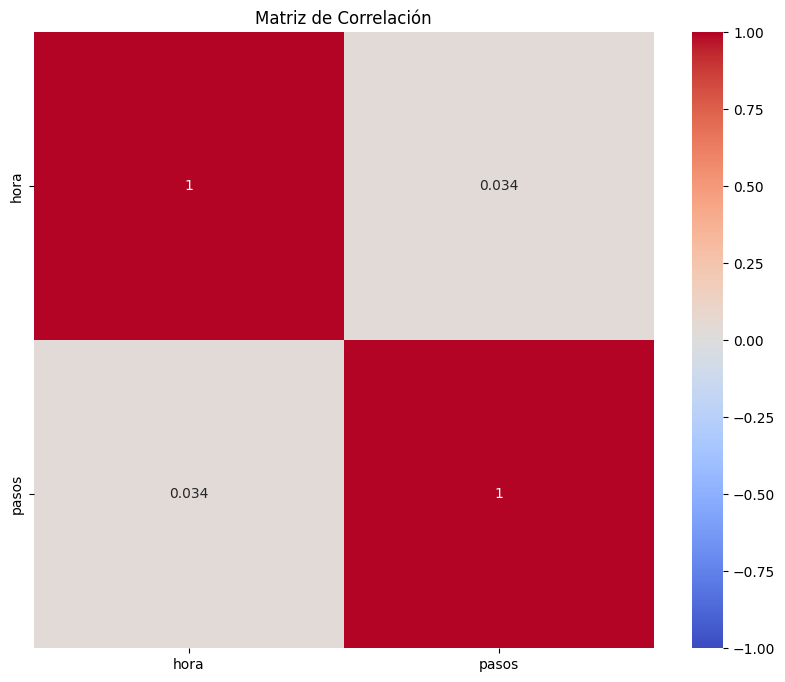

In [37]:
# Seleccionar solo columnas numéricas
numeric_columns = merged_data.select_dtypes(include=[np.number])

# Calcular la matriz de correlación
corr_matrix = numeric_columns.corr()

# Crear un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matriz de Correlación')
plt.show()

Análisis de valores atípicos

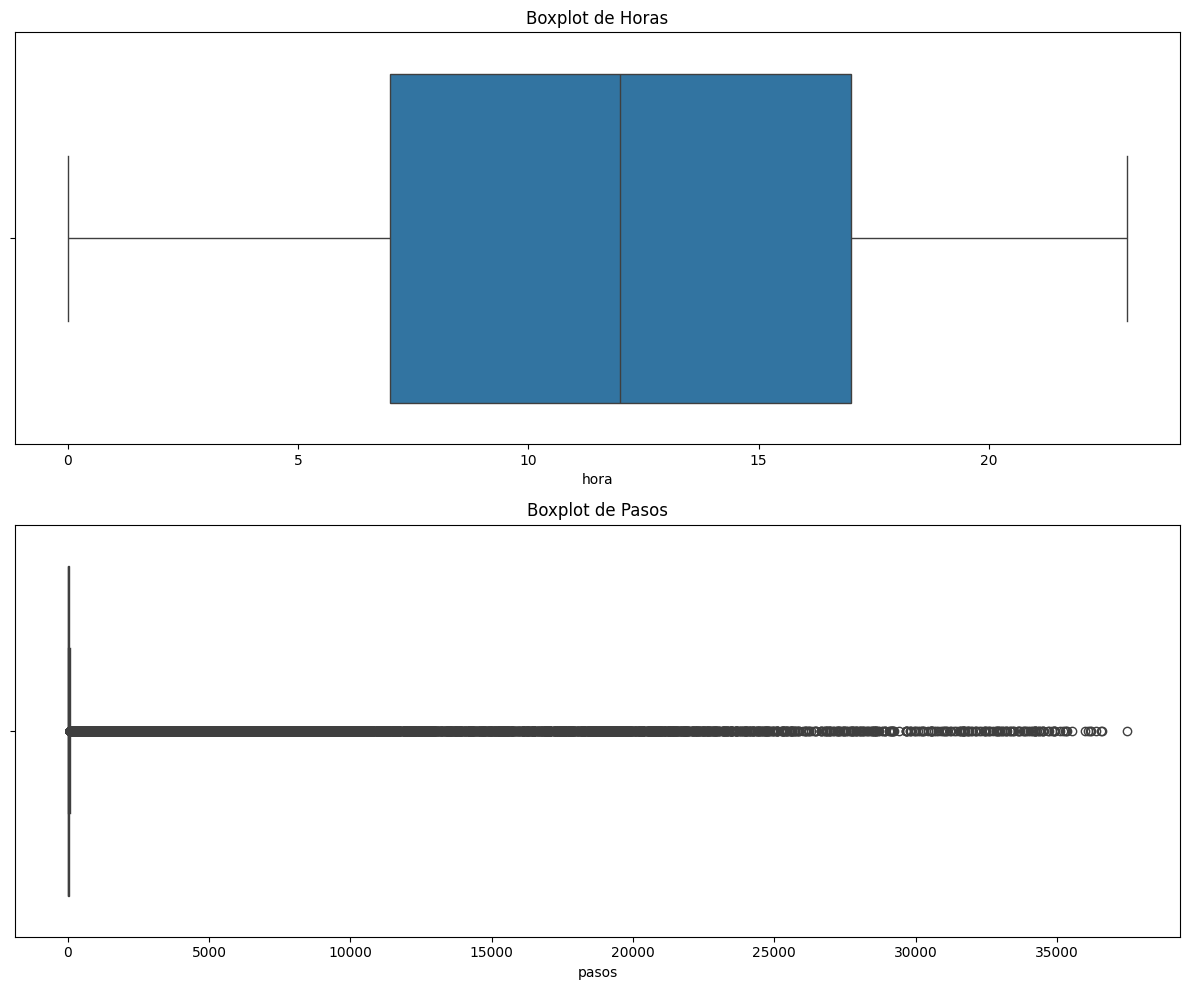

In [45]:
warnings.filterwarnings("ignore", category=FutureWarning)
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

sns.boxplot(data=merged_data, x='hora', ax=axes[0])
axes[0].set_title('Boxplot de Horas')

sns.boxplot(data=merged_data, x='pasos', ax=axes[1])
axes[1].set_title('Boxplot de Pasos')

plt.tight_layout()
plt.show()

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11093402 entries, 0 to 11093401
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   fecha          object 
 1   dia            object 
 2   hora           float64
 3   id_peaje       object 
 4   sentido        object 
 5   tipo_vehiculo  object 
 6   tipo_cobro     object 
 7   pasos          int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 677.1+ MB
None

Estadísticas descriptivas:
               hora         pasos
count  1.109340e+07  1.109340e+07
mean   1.215857e+01  1.021829e+02
std    6.363105e+00  4.590448e+02
min    0.000000e+00  0.000000e+00
25%    7.000000e+00  2.000000e+00
50%    1.200000e+01  8.000000e+00
75%    1.700000e+01  3.200000e+01
max    2.300000e+01  3.748000e+04

Valores nulos por columna:
fecha                 0
dia                   0
hora                  0
id_peaje              0
sentido               0
tipo_vehiculo    521574
tipo

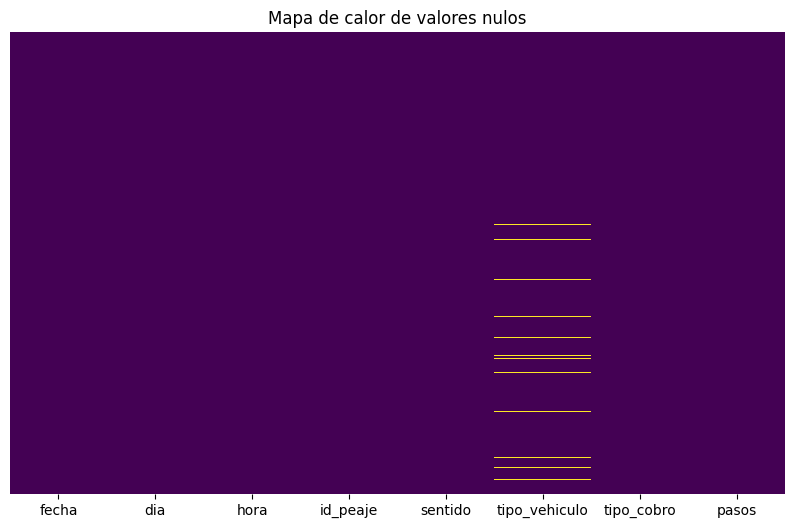


Outliers en hora:
Empty DataFrame
Columns: [hora, fecha]
Index: []


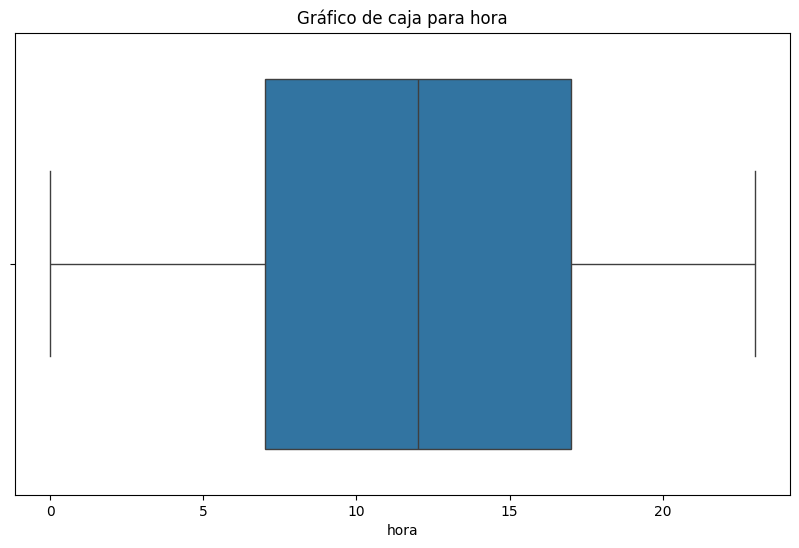


Outliers en pasos:
         pasos       fecha
520       1761  2016-01-01
561       1680  2016-01-01
1207      1857  2016-01-01
1243      2008  2016-01-01
1266      2445  2016-01-01
...        ...         ...
9523043   2009  2022-12-30
9524188   2572  2022-12-31
9524684   1889  2022-12-31
9525427   1564  2022-12-31
9526036   1501  2022-12-31

[173650 rows x 2 columns]


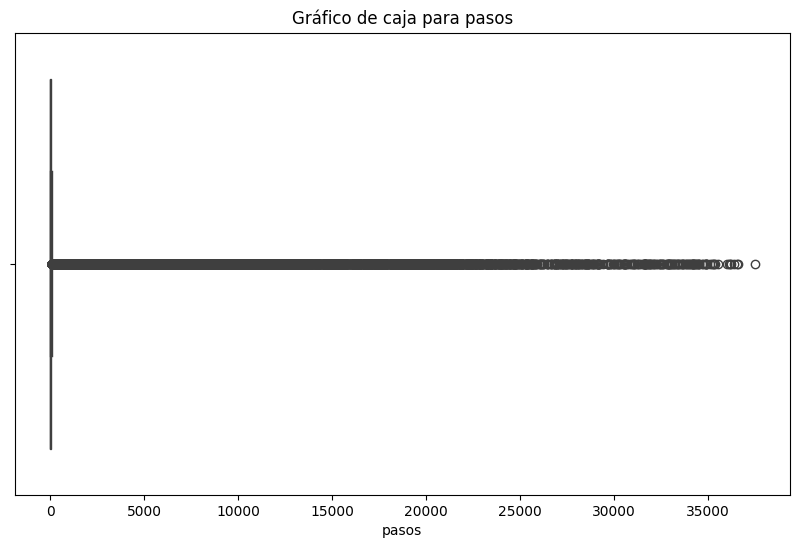

<Figure size 1200x1000 with 0 Axes>

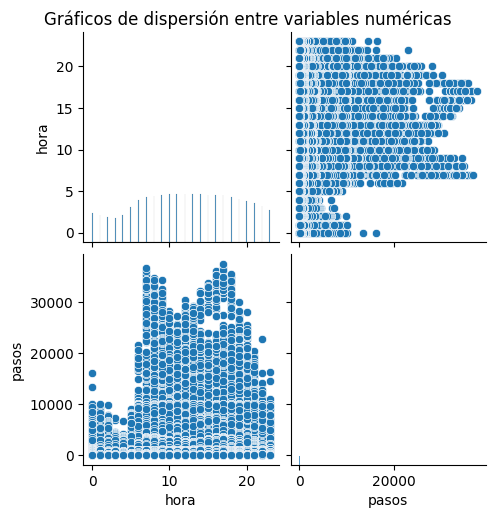

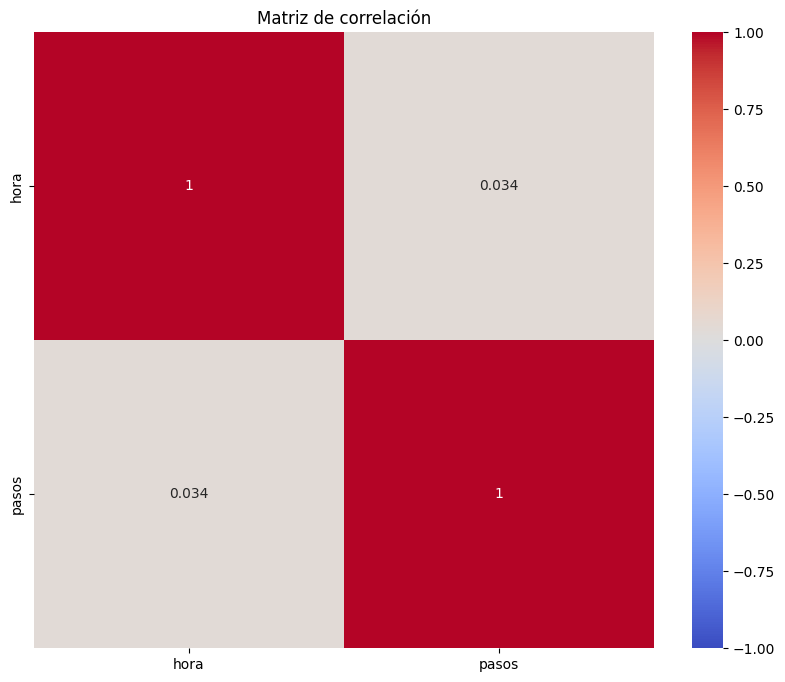

In [48]:
# 1. Análisis de columnas
print("Información del DataFrame:")
print(merged_data.info())

print("\nEstadísticas descriptivas:")
print(merged_data.describe())

# 2. Análisis de valores nulos
print("\nValores nulos por columna:")
print(merged_data.isnull().sum())

# Visualización de valores nulos
plt.figure(figsize=(10, 6))
sns.heatmap(merged_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Mapa de calor de valores nulos')
plt.show()

# 3. Manejo de valores nulos
# Aquí debes decidir cómo manejar los nulos. Por ejemplo:
# merged_data = merged_data.dropna()  # Eliminar filas con nulos
# O
# merged_data = merged_data.fillna(method='ffill')  # Rellenar con el valor anterior

# 4. Detección de outliers
def detect_outliers(df, column, threshold=3):
    z_scores = np.abs(stats.zscore(df[column]))
    return df[z_scores > threshold]

numeric_columns = merged_data.select_dtypes(include=[np.number]).columns

for column in numeric_columns:
    outliers = detect_outliers(merged_data, column)
    print(f"\nOutliers en {column}:")
    print(outliers[[column, 'fecha']])  # Mostramos la fecha para contexto

    # Gráfico de caja para visualizar outliers
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=merged_data[column])
    plt.title(f'Gráfico de caja para {column}')
    plt.show()

# 5. Gráfico de correlaciones
plt.figure(figsize=(12, 10))
sns.pairplot(merged_data[numeric_columns])
plt.suptitle('Gráficos de dispersión entre variables numéricas', y=1.02)
plt.show()

# 6. Matriz de correlación (mapa de calor)
correlation_matrix = merged_data[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de correlación')
plt.show()

## Análisis de variables categóricas



Distribución de dia:
dia
Jueves       0.152494
Miercoles    0.151954
Viernes      0.150989
Martes       0.149605
Lunes        0.145949
Sabado       0.129889
Domingo      0.119120
Name: proportion, dtype: float64


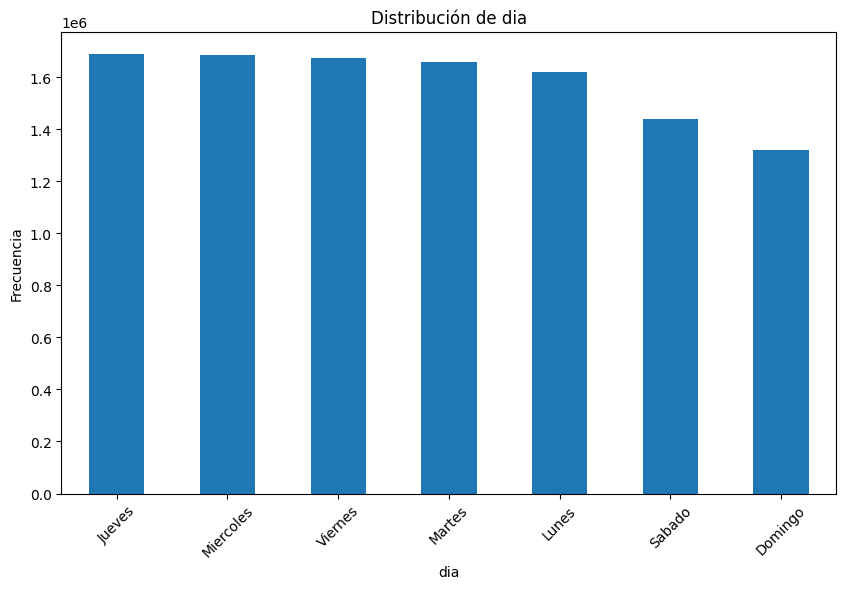


Distribución de id_peaje:
id_peaje
AVE    0.364573
ILL    0.201057
DEC    0.176069
ALB    0.123174
RET    0.067457
SAL    0.035140
SAR    0.032531
Name: proportion, dtype: float64


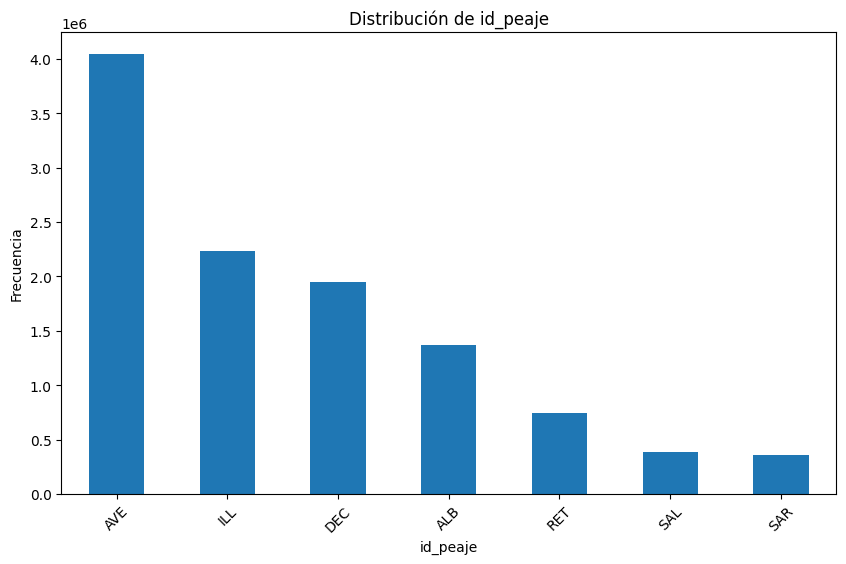


Distribución de sentido:
sentido
Centro       0.510243
Provincia    0.489757
Name: proportion, dtype: float64


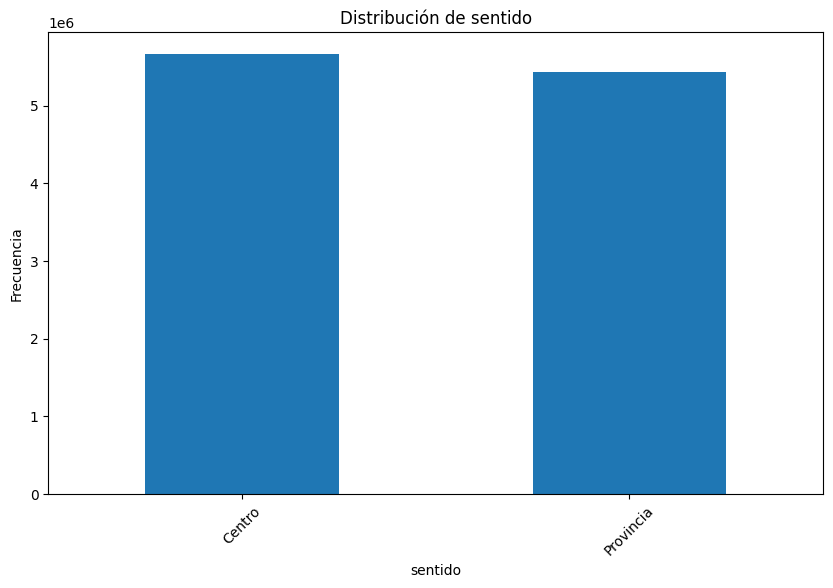


Distribución de tipo_vehiculo:
tipo_vehiculo
Liviano    0.515554
Pesado     0.484446
Name: proportion, dtype: float64


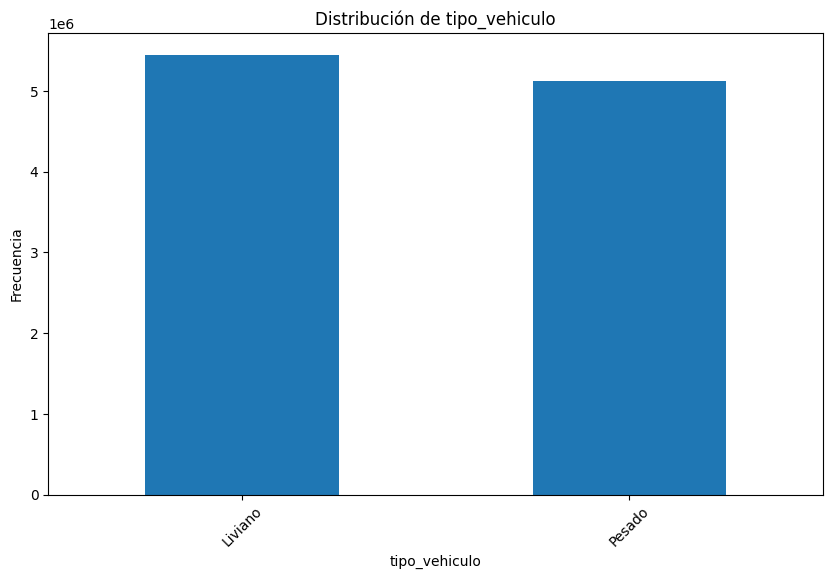


Distribución de tipo_cobro:
tipo_cobro
Tag                  0.366849
Efectivo             0.191354
Rec.Deuda            0.113326
Infraccion           0.112155
Exento               0.091160
Monedero virtual     0.057511
Tarjeta Magnetica    0.042164
Mercado Pago         0.023483
CPP                  0.001326
Otro                 0.000673
Name: proportion, dtype: float64


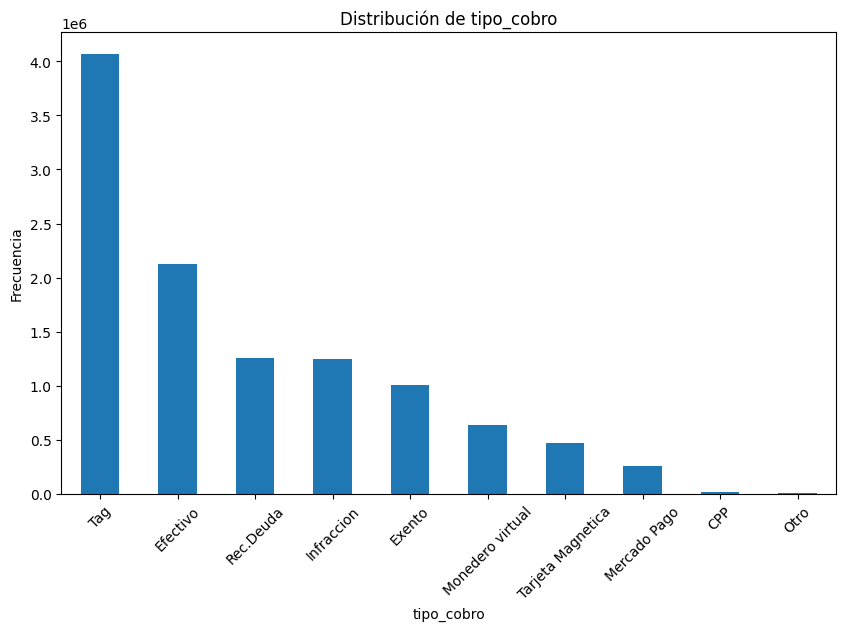

In [59]:
# Distribución de frecuencias:
for columna in ['dia', 'id_peaje', 'sentido', 'tipo_vehiculo', 'tipo_cobro']:
    print(f"\nDistribución de {columna}:")
    print(merged_data[columna].value_counts(normalize=True))
    
    plt.figure(figsize=(10, 6))
    merged_data[columna].value_counts().plot(kind='bar')
    plt.title(f'Distribución de {columna}')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.show()

<Figure size 1200x600 with 0 Axes>

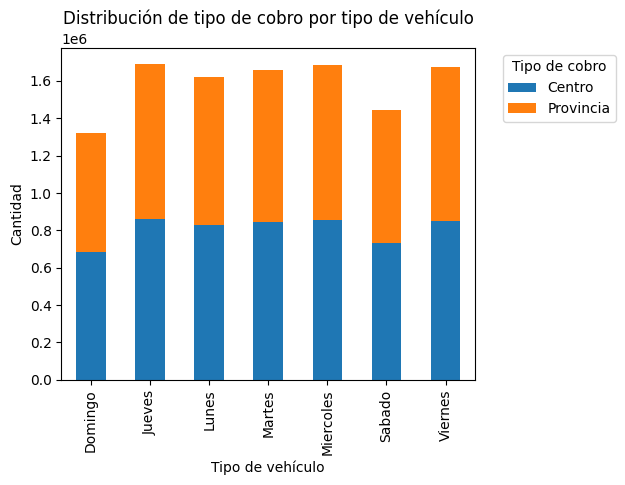

In [54]:
#Gráficos de barras apiladas para relaciones entre variables categóricas:
plt.figure(figsize=(12, 6))
merged_data.groupby(['dia', 'sentido']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Distribución de tipo de cobro por tipo de vehículo')
plt.xlabel('Tipo de vehículo')
plt.ylabel('Cantidad')
plt.legend(title='Tipo de cobro', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

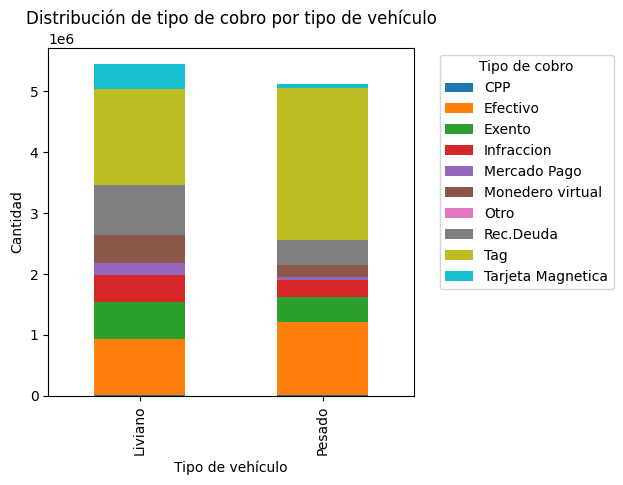

In [51]:
# Heatmap para visualizar la relación entre dos variables categóricas:
plt.figure(figsize=(12, 6))
merged_data.groupby(['tipo_vehiculo', 'tipo_cobro']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Distribución de tipo de cobro por tipo de vehículo')
plt.xlabel('Tipo de vehículo')
plt.ylabel('Cantidad')
plt.legend(title='Tipo de cobro', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

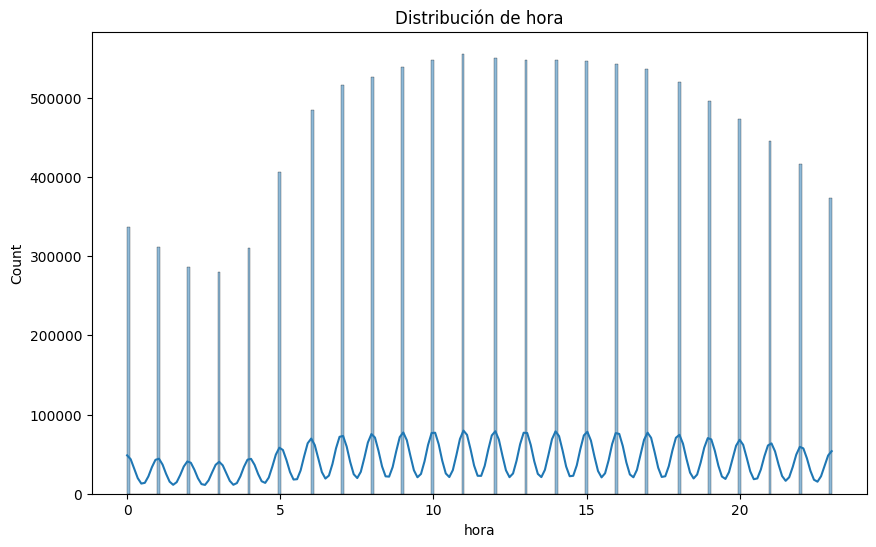

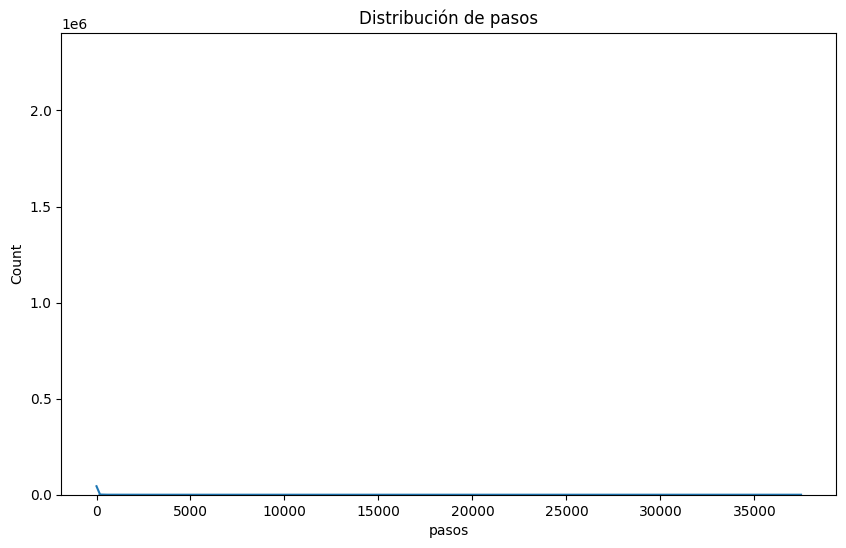

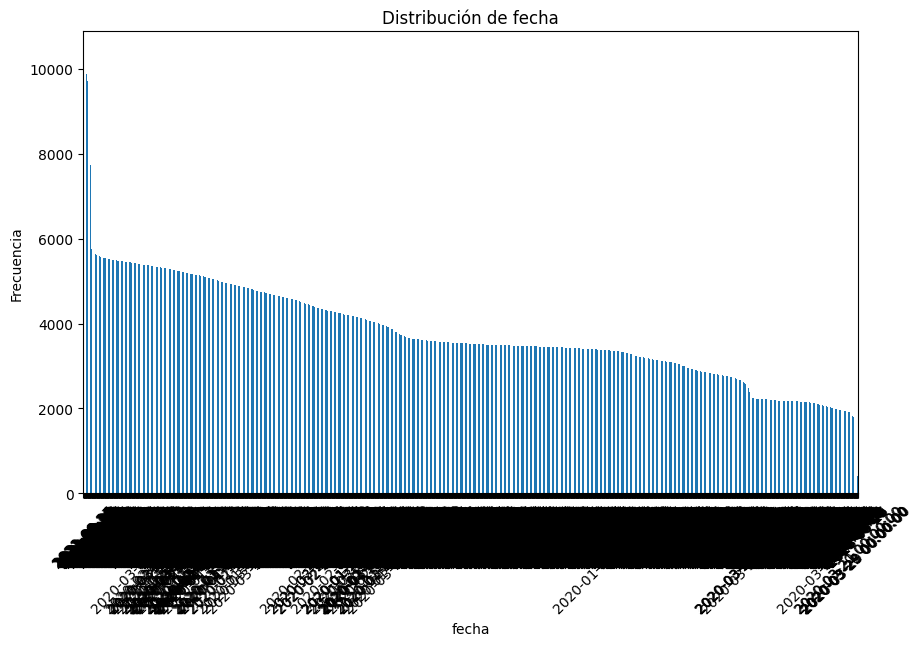

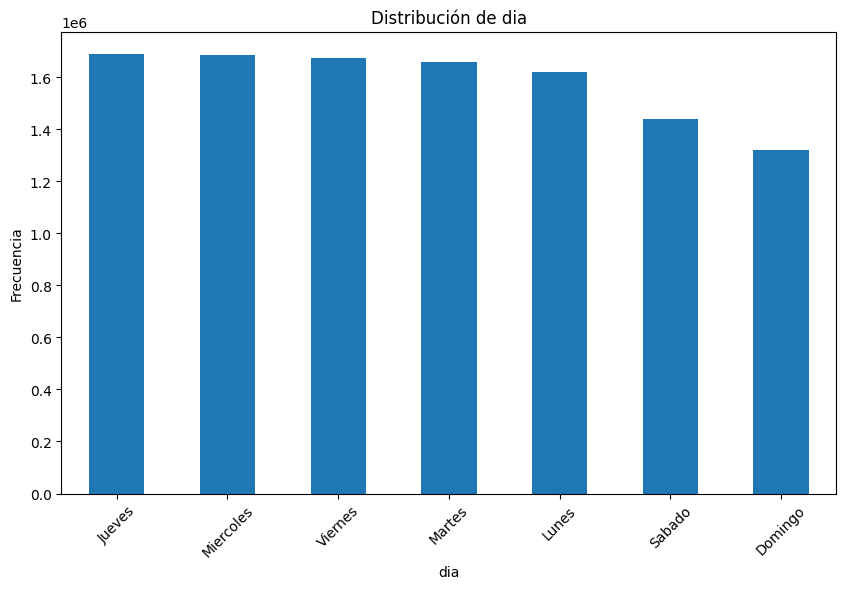

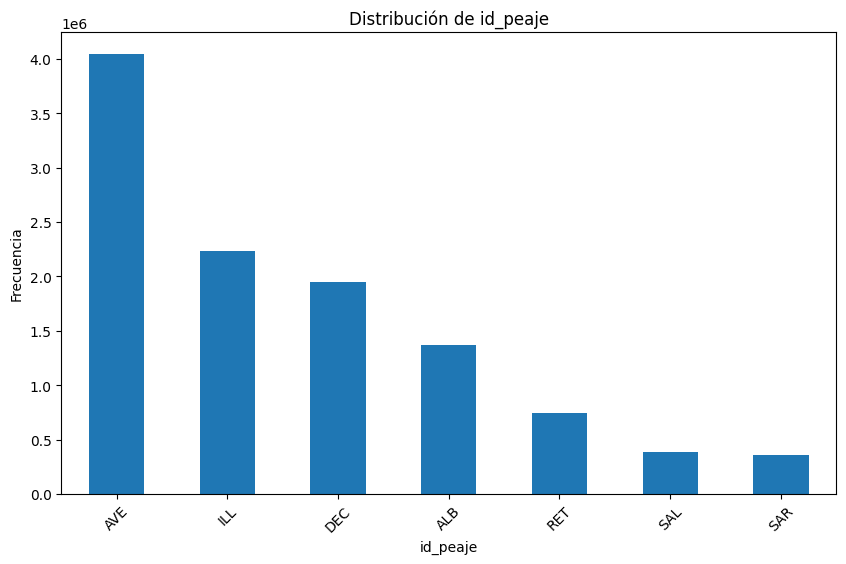

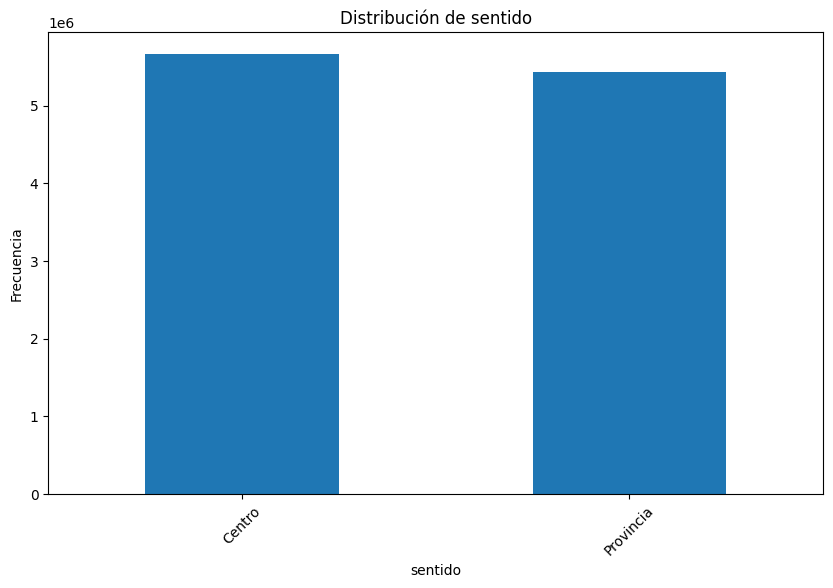

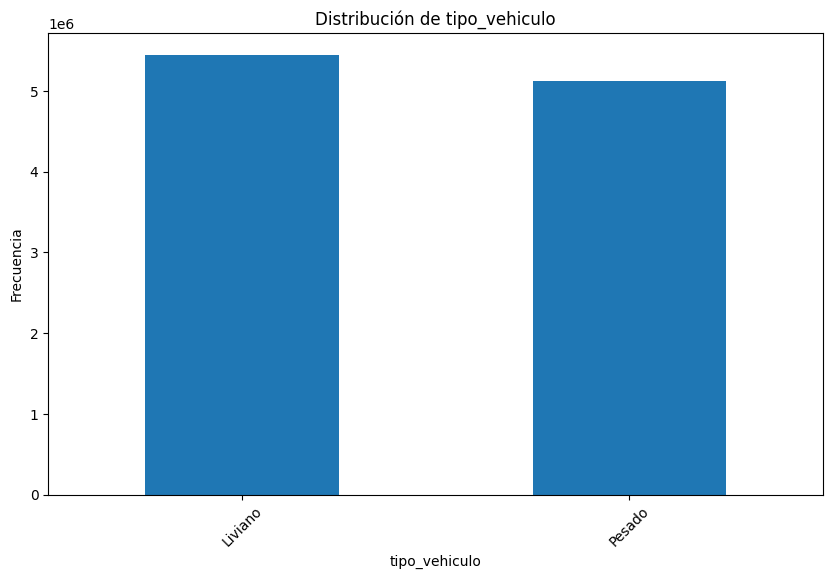

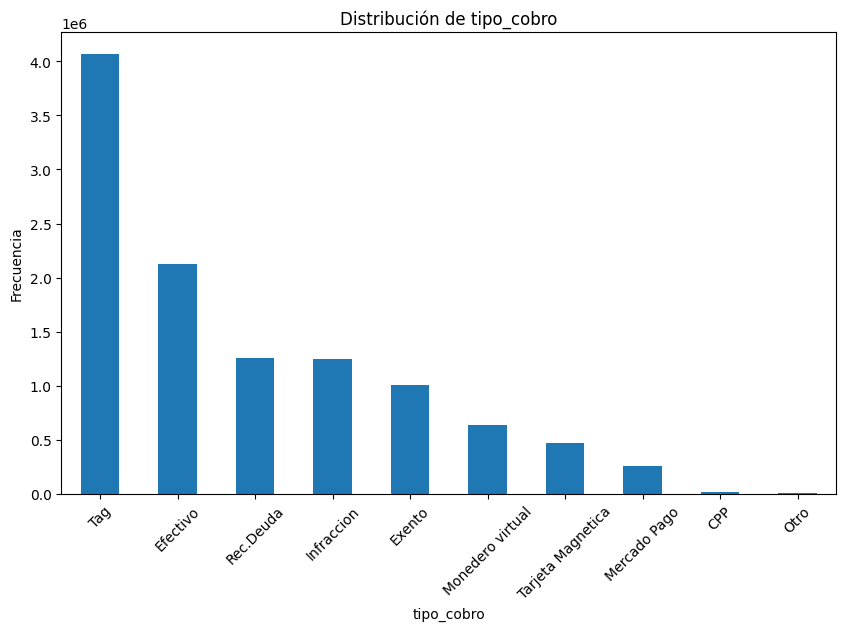

In [64]:
# Histogramas para variables numéricas
for columna in merged_data.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(merged_data[columna], kde=True)
    plt.title(f'Distribución de {columna}')
    plt.show()

# Gráficos de barras para variables categóricas
for columna in merged_data.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(10, 6))
    merged_data[columna].value_counts().plot(kind='bar')
    plt.title(f'Distribución de {columna}')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.show()

